In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
#from sklearn.metrics import r2_score
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.animation as animation # animation
import imageio 
import fiona
import rasterio
import rasterio.transform
import rasterio.mask
from fiona import Feature, Geometry
from shapely.geometry import mapping, shape
import os

In [2]:
common_years = np.arange(2005,2017)

#Get information from the shapefile
shape_file = '/Users/francesco/Desktop/squares.shp.gpkg'

ids = []
boundaries = []

# Open and extract boundaries
with fiona.open(shape_file, "r") as shapefile:
    for feature in shapefile:
        ids.append(int(feature['id'])) #id is registered as a string in the geometry file
        polygon = shape(feature['geometry'])
        bounds = polygon.bounds
        boundaries.append(bounds)

# Create a DataFrame with the information retrieved from the previous block
df = pd.DataFrame({'boundaries': boundaries}, index=ids)

# Sort the dataset according to the index
df = df.sort_index()
pd.set_option('display.max_rows', None)



In [3]:
#Load the masks

cnn_dataset_directory = '/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/'

ice_mask = np.load(cnn_dataset_directory + 'ice_mask.npy', allow_pickle=True)
land_mask = np.load(cnn_dataset_directory + 'land_mask.npy', allow_pickle=True)
sea_mask = np.load(cnn_dataset_directory + 'sea_mask.npy', allow_pickle=True)
grounded_ice_mask = np.load(cnn_dataset_directory + 'grounded_ice_mask.npy', allow_pickle=True)
boarders_mask = np.load(cnn_dataset_directory + 'boarders.npy', allow_pickle=True)

ice_mask = pd.DataFrame(ice_mask, index=df.index, columns=common_years)
land_mask = pd.DataFrame(land_mask, index=df.index, columns=common_years)
sea_mask = pd.DataFrame(sea_mask, index=df.index, columns=common_years)
grounded_ice_mask = pd.DataFrame(grounded_ice_mask, index=df.index, columns=common_years)
boarders_mask = pd.DataFrame(boarders_mask, index=df.index, columns=common_years)


In [4]:
#MULTI YEAR VELOCITY

velocity_multy_years_x_path = '/Users/francesco/Desktop/Thesis/ice_velocity/nasa_dataset/tif_converted/velocity_multi_years_X.tif'
velocity_multy_years_y_path = '/Users/francesco/Desktop/Thesis/ice_velocity/nasa_dataset/tif_converted/velocity_multi_years_Y.tif'

#dataset
velocity_multy_years_x =pd.DataFrame(index = df.index, columns = ['image'])
velocity_multy_years_y =pd.DataFrame(index = df.index, columns = ['image'])

#Extract the velocity data from the multi year dataset
for id in df.index:

        with rasterio.open(velocity_multy_years_x_path, crs = 'EPSG:3031') as src:
                xmin, ymin, xmax, ymax = df.loc[id, 'boundaries']
                window = rasterio.windows.from_bounds(xmin, ymin, xmax, ymax, src.transform)
                velocity_multy_years_x.loc[id, 'image'] = src.read(1, window=window)
                velocity_multy_years_x.loc[id, 'image'][velocity_multy_years_x.loc[id, 'image']==0] = np.nan

        with rasterio.open(velocity_multy_years_y_path, crs = 'EPSG:3031') as src:
                xmin, ymin, xmax, ymax = df.loc[id, 'boundaries']
                window = rasterio.windows.from_bounds(xmin, ymin, xmax, ymax, src.transform)
                velocity_multy_years_y.loc[id,'image'] = src.read(1, window=window)
                velocity_multy_years_y.loc[id, 'image'][velocity_multy_years_y.loc[id, 'image']==0] = np.nan


Total nan pixels:  529462
Not a NaN pixels:  519114


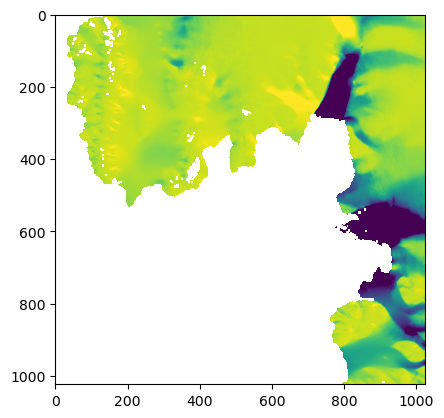

In [5]:
#multi year velocity
x = velocity_multy_years_x.loc[1, 'image']
x[x == 0] = np.nan
plt.imshow(x, cmap='viridis', vmin = -1000, vmax = 100)

#count the numebr of nan in velocity_multy_years_x.loc[1, 'image']
total_nan_pixels = np.sum(np.isnan(velocity_multy_years_x.loc[1, 'image']))
not_a_nan_pixels = np.sum(~np.isnan(velocity_multy_years_x.loc[1, 'image']))

print('Total nan pixels: ', total_nan_pixels)
print('Not a NaN pixels: ', not_a_nan_pixels)

In [6]:
#EXTRACTING SINGLE YEAR VELOCITY

list_x = []
list_y = []

#Velocity
velocity_x_tif = pd.DataFrame(index = df.index, columns = common_years)
velocity_y_tif = pd.DataFrame(index = df.index, columns = common_years)

common_years = np.arange(2005,2017,1)

#FILE LIST (change in cluster)
for i in common_years:
    list_x.append('/Users/francesco/Desktop/Thesis/ice_velocity/nasa_dataset/tif_converted/' + f"{i}_{i+1}_VX.tif")
    list_y.append('/Users/francesco/Desktop/Thesis/ice_velocity/nasa_dataset/tif_converted/' + f"{i}_{i+1}_VY.tif")

#calculate the velocity for each year, for each region

for name_x, name_y, year in zip(list_x, list_y, common_years): #for each year

    for id in df.index: #for each region

        xmin, ymin, xmax, ymax = df.loc[id, 'boundaries']

        with rasterio.open(name_x, crs = 'EPSG:3031') as src:
            window = rasterio.windows.from_bounds(xmin, ymin, xmax, ymax, src.transform)
            image_x = src.read(1, window=window)

            #Exclude the 0.01 and 99.99 percentile
            values = np.nanpercentile(image_x.ravel(), [0.05, 99.95])
            image_x[image_x < values[0]] = np.nan
            image_x[image_x > values[1]] = np.nan

            #set to nan all the 0 values
            image_x[image_x == 0] = np.nan
            velocity_x_tif.loc[id, year] = image_x

        with rasterio.open(name_y, crs = 'EPSG:3031') as src:
            window = rasterio.windows.from_bounds(xmin, ymin, xmax, ymax, src.transform)
            image_y = src.read(1, window=window)

            #Exclude the 0.05 and 99.95 percentile
            values = np.nanpercentile(image_y.ravel(), [0.05, 99.95])
            image_y[image_y < values[0]] = np.nan
            image_y[image_y > values[1]] = np.nan

            #set to nan all the 0 values
            image_y[image_y == 0] = np.nan
            velocity_y_tif.loc[id, year] = image_y

        

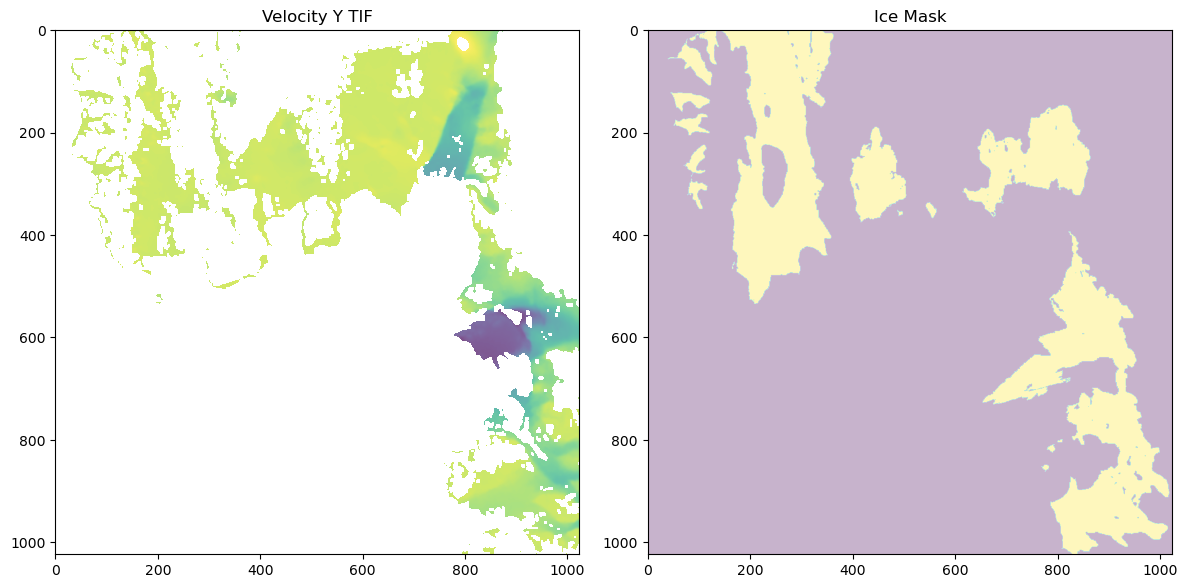

In [7]:
i =1
year = 2011
prova_2 = velocity_x_tif.loc[i, year]

# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# Plot the first image (velocity_y_tif)
plt.subplot(1, 2, 1)
plt.imshow(prova_2, cmap='viridis', alpha=0.7)
plt.title('Velocity Y TIF')

# Plot the second image (~sea_mask)
plt.subplot(1, 2, 2)
plt.imshow(ice_mask.loc[i, year], cmap='viridis', alpha=0.3)
plt.title('Ice Mask')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [8]:
#Smoothing and thresholding

from silx.image.medianfilter import medfilt2d

velocity_x_tif_smoothed = velocity_x_tif.copy()
velocity_y_tif_smoothed = velocity_y_tif.copy()

kernel_size = 4
threshold = 50

for id in df.index:
    for year in common_years:

        #smothering
        vx_tmp_smoothed = medfilt2d(velocity_x_tif_smoothed.loc[id, year], kernel_size)
        vy_tmp_smoothed = medfilt2d(velocity_y_tif_smoothed.loc[id, year], kernel_size)

        #thresholding
        velocity_x_tif_smoothed.loc[id, year][abs(velocity_x_tif_smoothed.loc[id, year] - vx_tmp_smoothed) > threshold] = np.nan
        velocity_y_tif_smoothed.loc[id, year][abs(velocity_y_tif_smoothed.loc[id, year] - vy_tmp_smoothed) > threshold] = np.nan


Special interpolation Pine Island

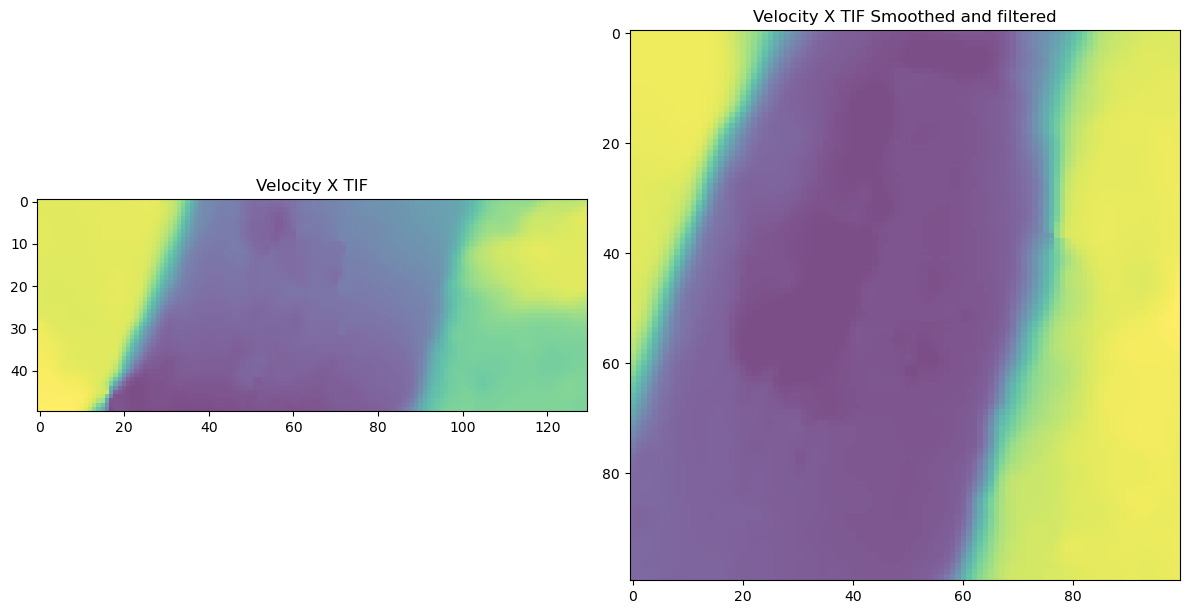

In [198]:
#plot both [250:300, 700:750] for Pine Island
year = 2011
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(velocity_x_tif_smoothed.loc[1, year][200:250, 720:850], cmap='viridis', alpha=0.7)
plt.title('Velocity X TIF')

plt.subplot(1, 2, 2)
plt.imshow(velocity_y_tif_smoothed.loc[1, year][150:250, 750:850], cmap='viridis', alpha=0.7)
plt.title('Velocity X TIF Smoothed and filtered')

plt.tight_layout()
plt.show()

In [197]:
#proviamo a interpolare subito
from skimage.restoration import inpaint

mask_nan = np.isnan(velocity_x_tif_smoothed.loc[1, year][200:250, 720:850])

velocity_x_tif_smoothed.loc[1, year][200:250, 720:850] = inpaint.inpaint_biharmonic(velocity_x_tif_smoothed.loc[1, year][200:250, 720:850], mask_nan)

mask_nan_2 = np.isnan(velocity_y_tif_smoothed.loc[1, year][150:250, 750:850])

velocity_y_tif_smoothed.loc[1, year][150:250, 750:850] = inpaint.inpaint_biharmonic(velocity_y_tif_smoothed.loc[1, year][150:250, 750:850], mask_nan_2)





Here i will calculate the coverage with the new methods

In [199]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

ice_shelves_masks = pd.DataFrame(index = df.index, columns = common_years)
number_of_ice_shelves = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:
        
        ice_shelf_mask = ice_mask.loc[id, year]
        ice_shelf_grounded_ice_mask = grounded_ice_mask.loc[id, year]

        combined_mask = ice_shelf_mask | ice_shelf_grounded_ice_mask

        # Perform connected component labeling on the mask
        labeled_mask, num_labels = label(combined_mask)

        # Create a new array to hold the labeled mask with unique labels for each ice shelf
        labeled_combined = np.zeros_like(labeled_mask)

        # Assign unique labels to each ice shelf
        for label_idx in range(1, num_labels + 1):  # Start from 1 to exclude background label
            ice_shelf = labeled_mask == label_idx
            labeled_combined[ice_shelf] = label_idx

        # Store the labeled mask and the number of ice shelves
            
        ice_shelves_masks.loc[id,year] = labeled_combined
        number_of_ice_shelves.loc[id,year] = num_labels



The number of ice shelves in the year 2005 is 1    185
Name: 2005, dtype: object
The number of ice shelves in the year 2006 is 1    185
Name: 2006, dtype: object
The number of ice shelves in the year 2007 is 1    186
Name: 2007, dtype: object
The number of ice shelves in the year 2008 is 1    183
Name: 2008, dtype: object
The number of ice shelves in the year 2009 is 1    185
Name: 2009, dtype: object
The number of ice shelves in the year 2010 is 1    192
Name: 2010, dtype: object
The number of ice shelves in the year 2011 is 1    196
Name: 2011, dtype: object
The number of ice shelves in the year 2012 is 1    199
Name: 2012, dtype: object
The number of ice shelves in the year 2013 is 1    197
Name: 2013, dtype: object
The number of ice shelves in the year 2014 is 1    207
Name: 2014, dtype: object
The number of ice shelves in the year 2015 is 1    208
Name: 2015, dtype: object
The number of ice shelves in the year 2016 is 1    213
Name: 2016, dtype: object


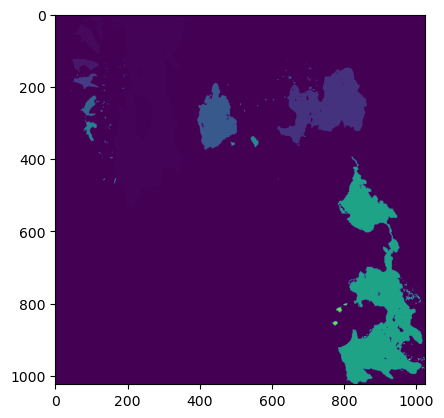

In [200]:
plt.imshow(ice_shelves_masks.loc[1,2013])

for year in common_years:
    print('The number of ice shelves in the year', year, 'is', number_of_ice_shelves[year])

In [201]:
#The mask with all the ice shelves with coverage larger than 70%
masks_filtered = pd.DataFrame(index = df.index, columns = common_years)


for id in df.index:

    for year in common_years:

        prova = ice_shelves_masks.loc[id,year]
        prova_id = number_of_ice_shelves.loc[id,year]

        prova_filtered = prova.copy()
        ice_shelves_numbers = np.arange(1,prova_id+1,1)

        #From here we are working on the single ice shelf
        j = 0

        for i in range(1,prova_id+1):
            #print(i)

            ice_shelf_mask = prova == ice_shelves_numbers[j] #Get the mask of ice shelf number n

            ice_shelf_mask = ice_shelf_mask.astype(bool) #convert ice_shelf_mask to boolean

            #Select the data from data_in_ice_shelf which are in the region ice_shelf_mask
            data_in_ice_shelf_roi = np.where(ice_shelf_mask, velocity_x_tif.loc[id, year], np.nan)

            # Count the number of non-NaN pixels in the masked data_in_ice_shelf_roi
            num_non_nan_pixels = np.sum(~np.isnan(data_in_ice_shelf_roi))

            # Count the number of True pixels in the ice_shelf_mask
            num_true_pixels = np.sum(ice_shelf_mask)

            # Calculate the ratio of non-NaN pixels to True pixels
            ratio_non_nan_to_true = num_non_nan_pixels / num_true_pixels
            #print('Ratio of non-NaN pixels to True pixels:', ratio_non_nan_to_true)

            if ratio_non_nan_to_true < 0.7:

                prova_filtered = np.where(prova_filtered == ice_shelves_numbers[j], 0, prova_filtered)
                #print('Ice shelf number ', ice_shelves_numbers[i], ' has been filtered out')
            j = j+1

        masks_filtered.loc[id,year] = prova_filtered


In [202]:
#Convert all the mask to the same boolean format

for id in df.index:
    for year in common_years:
        masks_filtered.loc[id,year] = masks_filtered.loc[id,year].astype(bool)

In [203]:
#interpolate into the ice shelf mask
from skimage.restoration import inpaint

interpolated_floating_ice_x = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:
        print(year)
        
        data_tmp = np.where(masks_filtered.loc[id,year], velocity_x_tif_smoothed.loc[id,year], np.nan)
        data_tmp = np.where(~masks_filtered.loc[id,year], velocity_x_tif_smoothed.loc[id,year], data_tmp)
        nan_mask = np.isnan(data_tmp)

        interpolated_floating_ice_x.loc[id,year] = inpaint.inpaint_biharmonic(data_tmp, nan_mask)
        interpolated_floating_ice_x.loc[id,year][~masks_filtered.loc[id,year]] = np.nan

        

2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [205]:
#save the interpolated_floating_ice_copy as a npy file
#np.save('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/interpolated_floating_ice_x.npy', interpolated_floating_ice_x)

In [206]:
#Load the interpolated_floating_ice_copy
interpolated_floating_ice_x = np.load('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/interpolated_floating_ice_x.npy', allow_pickle=True)
interpolated_floating_ice_x = pd.DataFrame(interpolated_floating_ice_x, index=df.index, columns=common_years)

In [207]:
#Now i interpolate the grounded ice

interpolated_ice_x = pd.DataFrame(index = df.index, columns = common_years)
coverage_ratio_x = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        #load original data for the land
        data_tmp = velocity_x_tif_smoothed.loc[id,year]

        #load the  interpolated data for the floating ice
        data_tmp_all_ice = np.where(masks_filtered.loc[id,year], interpolated_floating_ice_x.loc[id,year], data_tmp)
        nan_mask = np.isnan(data_tmp_all_ice)

        #Calculate the coverage ratio
        num_non_nan_pixels = np.sum(~np.isnan(data_tmp_all_ice))
        num_true_pixels = np.sum(~sea_mask.loc[id,year])

        coverage_ratio_x.loc[id,year] = num_non_nan_pixels/num_true_pixels

        print('The ratio of non-NaN pixels to True pixels for the year', year, 'is', coverage_ratio_x.loc[id,year])

        interpolated_ice_x.loc[id,year] = data_tmp_all_ice

        if coverage_ratio_x.loc[id,year] > 0.7:

            interpolated_ice_x.loc[id,year] = inpaint.inpaint_biharmonic(data_tmp_all_ice, nan_mask)
            interpolated_ice_x.loc[id,year][sea_mask.loc[id,year]] = np.nan

The ratio of non-NaN pixels to True pixels for the year 2005 is 0.5032039616009916
The ratio of non-NaN pixels to True pixels for the year 2006 is 0.3291390284507577
The ratio of non-NaN pixels to True pixels for the year 2007 is 0.7636996860894923
The ratio of non-NaN pixels to True pixels for the year 2008 is 0.8394801792434329
The ratio of non-NaN pixels to True pixels for the year 2009 is 0.6167632820592934
The ratio of non-NaN pixels to True pixels for the year 2010 is 0.7721129035582648
The ratio of non-NaN pixels to True pixels for the year 2011 is 0.4935797508436836
The ratio of non-NaN pixels to True pixels for the year 2012 is 0.28572921158562414
The ratio of non-NaN pixels to True pixels for the year 2013 is 0.9555860371802735
The ratio of non-NaN pixels to True pixels for the year 2014 is 0.9801468938677175
The ratio of non-NaN pixels to True pixels for the year 2015 is 0.8365136336223806
The ratio of non-NaN pixels to True pixels for the year 2016 is 0.9610757087654118


In [208]:
#save as npy file
#np.save('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/interpolated_ice_x.npy', interpolated_ice_x)
#np.save('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/coverage_ratio_x.npy', coverage_ratio_x)

#load the interpolated_ice_x
interpolated_ice_x = np.load('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/interpolated_ice_x.npy', allow_pickle=True)
interpolated_ice_x = pd.DataFrame(interpolated_ice_x, index=df.index, columns=common_years)

#load the coverage_ratio_x
coverage_ratio_x = np.load('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/coverage_ratio_x.npy', allow_pickle=True)
coverage_ratio_x = pd.DataFrame(coverage_ratio_x, index=df.index, columns=common_years)

In [209]:
#Redoing it for y
from skimage.restoration import inpaint

interpolated_floating_ice_y = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:
        print(year)
        
        data_tmp = np.where(masks_filtered.loc[id,year], velocity_y_tif_smoothed.loc[id,year], np.nan)
        data_tmp = np.where(~masks_filtered.loc[id,year], velocity_y_tif_smoothed.loc[id,year], data_tmp)
        nan_mask = np.isnan(data_tmp)

        interpolated_floating_ice_y.loc[id,year] = inpaint.inpaint_biharmonic(data_tmp, nan_mask)
        interpolated_floating_ice_y.loc[id,year][~masks_filtered.loc[id,year]] = np.nan


2005


2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [210]:
#save the interpolated_floating_ice_y as a npy file
#np.save('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/interpolated_floating_ice_y.npy', interpolated_floating_ice_y)


In [211]:
#Now i interpolate the grounded ice

interpolated_ice_y = pd.DataFrame(index = df.index, columns = common_years)
coverage_ratio_y = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        #load original data for the land
        data_tmp = velocity_y_tif_smoothed.loc[id,year]

        #load the  interpolated data for the floating ice
        data_tmp_all_ice = np.where(masks_filtered.loc[id,year], interpolated_floating_ice_y.loc[id,year], data_tmp)
        nan_mask = np.isnan(data_tmp_all_ice)

        #Calculate the coverage ratio
        num_non_nan_pixels = np.sum(~np.isnan(data_tmp_all_ice))
        num_true_pixels = np.sum(~sea_mask.loc[id,year])

        coverage_ratio_y.loc[id,year] = num_non_nan_pixels/num_true_pixels

        print('The ratio of non-NaN pixels to True pixels for the year', year, 'is', coverage_ratio_y.loc[id,year])

        interpolated_ice_y.loc[id,year] = data_tmp_all_ice

        if coverage_ratio_y.loc[id,year] > 0.7:

            interpolated_ice_y.loc[id,year] = inpaint.inpaint_biharmonic(data_tmp_all_ice, nan_mask)
            interpolated_ice_y.loc[id,year][sea_mask.loc[id,year]] = np.nan

The ratio of non-NaN pixels to True pixels for the year 2005 is 0.5042772374067417
The ratio of non-NaN pixels to True pixels for the year 2006 is 0.3292284142585261
The ratio of non-NaN pixels to True pixels for the year 2007 is 0.7647231457919275


The ratio of non-NaN pixels to True pixels for the year 2008 is 0.8404515128752585
The ratio of non-NaN pixels to True pixels for the year 2009 is 0.6177340854269768
The ratio of non-NaN pixels to True pixels for the year 2010 is 0.773130407245076
The ratio of non-NaN pixels to True pixels for the year 2011 is 0.4946546384307016
The ratio of non-NaN pixels to True pixels for the year 2012 is 0.28678732017378056
The ratio of non-NaN pixels to True pixels for the year 2013 is 0.9565553012554001
The ratio of non-NaN pixels to True pixels for the year 2014 is 0.981063761302342
The ratio of non-NaN pixels to True pixels for the year 2015 is 0.837514857340258
The ratio of non-NaN pixels to True pixels for the year 2016 is 0.962122102820953


In [212]:
#Specific treatment for Pine Island in year 2006
from skimage.restoration import inpaint

mask_nan_pi = np.isnan(interpolated_ice_y.loc[1,2006][150:225, 790:812])

interpolated_ice_y.loc[1,2006][150:225, 790:812] = inpaint.inpaint_biharmonic(interpolated_ice_y.loc[1,2006][150:225, 790:812], mask_nan_pi)

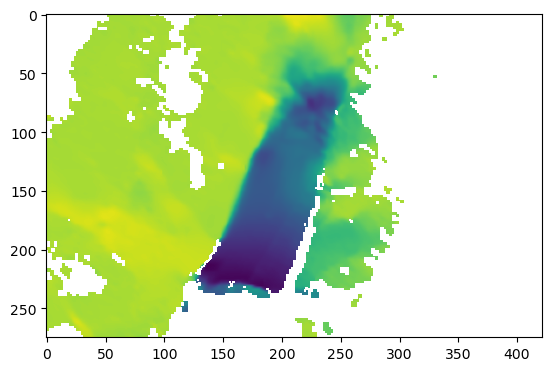

In [213]:
plt.imshow(velocity_x_tif_smoothed.loc[1,2012][50:325, 590:1012])

In [215]:
#save as npy file
#np.save('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/interpolated_ice_y.npy', interpolated_ice_y)
#np.save('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/coverage_ratio_y.npy', coverage_ratio_y)

#load the interpolated_ice_y
interpolated_ice_y = np.load('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/interpolated_ice_y.npy', allow_pickle=True)
interpolated_ice_y = pd.DataFrame(interpolated_ice_y, index=df.index, columns=common_years)

#load the coverage_ratio_y
coverage_ratio_y = np.load('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/coverage_ratio_y.npy', allow_pickle=True)
coverage_ratio_y = pd.DataFrame(coverage_ratio_y, index=df.index, columns=common_years)

START FROM HERE

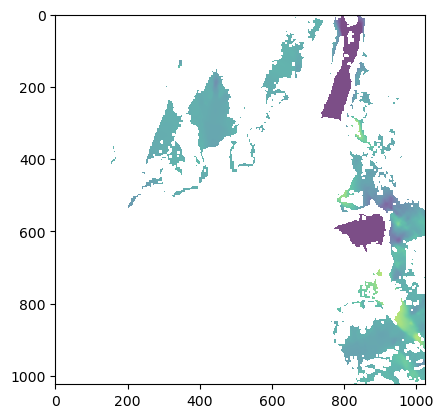

In [216]:
plt.imshow(interpolated_ice_y.loc[1,2006], cmap='viridis', alpha=0.7, vmin=-1000, vmax=1000)

In [217]:
threshold_interpolation = 0.7

In [218]:
#here we Calcualtate the ratios

ratios_x = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:


        ratios_x.loc[id, year] = interpolated_ice_x.loc[id, year] / velocity_multy_years_x.loc[id, 'image']


#Now I set to 0 all the values which are not in the see but nan. 
#Because in the multi year velocity we have 0 values not in the sea,
#and the ratio is ofcourse impossible to calculate
for id in df.index:
    for year in common_years:

        if coverage_ratio_x.loc[id, year]  > threshold_interpolation:

            mask_nan_and_not_sea = np.logical_and(~sea_mask.loc[id, year], np.isnan(ratios_x.loc[id, year]))
            ratios_x.loc[id, year][mask_nan_and_not_sea] = 0


#Same for y
ratios_y = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        ratios_y.loc[id, year] = interpolated_ice_y.loc[id, year] / velocity_multy_years_y.loc[id, 'image']

for id in df.index:
    for year in common_years:

        if coverage_ratio_y.loc[id, year]  > threshold_interpolation:
  
            mask_nan_and_not_sea = np.logical_and(~sea_mask.loc[id, year], np.isnan(ratios_y.loc[id, year]))
            ratios_y.loc[id, year][mask_nan_and_not_sea] = 0

        

In [28]:
# #here we Calcualtate the ratios

# ratios_x = pd.DataFrame(index = df.index, columns = common_years)

# for id in df.index:
#     for year in common_years:

#         if coverage_ratio_x.loc[id, year]  > threshold_interpolation:
#             ratios_x.loc[id, year] = interpolated_ice_x.loc[id, year] / velocity_multy_years_x.loc[id, 'image']

#         else:    
#             ratios_x.loc[id, year] = velocity_x_tif_smoothed.loc[id, year] / velocity_multy_years_x.loc[id, 'image']


# #Now I set to 0 all the values which are not in the see but nan. 
# #Because in the multi year velocity we have 0 values not in the sea,
# #and the ratio is ofcourse impossible to calculate
# for id in df.index:
#     for year in common_years:

#         if coverage_ratio_x.loc[id, year]  > threshold_interpolation:
  
#             mask_nan_and_not_sea = np.logical_and(~sea_mask.loc[id, year], np.isnan(ratios_x.loc[id, year]))
#             ratios_x.loc[id, year][mask_nan_and_not_sea] = 0


# #Same for y
# ratios_y = pd.DataFrame(index = df.index, columns = common_years)

# for id in df.index:
#     for year in common_years:

#         if coverage_ratio_y.loc[id, year]  > threshold_interpolation:
#             ratios_y.loc[id, year] = interpolated_ice_y.loc[id, year] / velocity_multy_years_y.loc[id, 'image']

#         else:    
#             ratios_y.loc[id, year] = velocity_y_tif_smoothed.loc[id, year] / velocity_multy_years_y.loc[id, 'image']

# for id in df.index:
#     for year in common_years:

#         if coverage_ratio_y.loc[id, year]  > threshold_interpolation:
  
#             mask_nan_and_not_sea = np.logical_and(~sea_mask.loc[id, year], np.isnan(ratios_y.loc[id, year]))
#             ratios_y.loc[id, year][mask_nan_and_not_sea] = 0

        

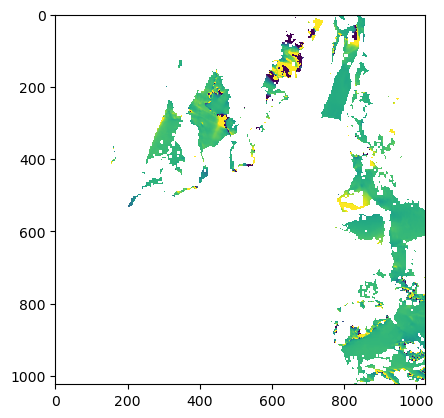

In [219]:
plt.imshow(ratios_x.loc[1, 2006], cmap='viridis', vmin = -1, vmax = 2)

Here i reshape the dataset in order to perform pixel by pixel interpolation

In [220]:
raveled_vector_x = np.zeros((len(df.index),len(ratios_x.loc[id, year].ravel()), len(common_years))) 

index = 0
for id in df.index:

    time = 0

    for year in common_years:

        matrix = ratios_x.loc[id, year]
        array_raveled = matrix.ravel()
        raveled_vector_x[index, :,time] = array_raveled
        time = time + 1

    index = index + 1


#Redoing it for y
raveled_vector_y = np.zeros((len(df.index),len(ratios_y.loc[id, year].ravel()), len(common_years)))
index = 0

for id in df.index:
        
        time = 0
    
        for year in common_years:
    
            matrix = ratios_y.loc[id, year]
            array_raveled = matrix.ravel()
            raveled_vector_y[index, :,time] = array_raveled
            time = time + 1
    
        index = index + 1

N.B: The inteprolation functions are reported down in the code

In [221]:
#step by step interpolation  x

for i in range(len(df.index)): #for each region
   for j in range(len(ratios_x.loc[id, year].ravel())): #for each pixel of the region

      #take the values of the pixel
      x = raveled_vector_x[i, j, :] #here I am taking the ratio time serie for each pixel

      #If the value is all nan, skip to the next pixel
      if np.isnan(x).all() == True:
          continue

      #interpolate the nan values as the average of the two closest values
      x = interpolation_excluding_extreames(x)

      x = fill_fist_values(x)

      raveled_vector_x[i, j, :] = x

#step by step interpolation  y
      
for i in range(len(df.index)): #for each region
   for j in range(len(ratios_y.loc[id, year].ravel())): #for each pixel of the region

      #take the values of the pixel
      y = raveled_vector_y[i, j, :] #here I am taking the ratio time serie for each pixel

      #If the value is all nan, skip to the next pixel
      if np.isnan(y).all() == True:
          continue

      #interpolate the nan values as the average of the two closest values
      y = interpolation_excluding_extreames(y)

      y = fill_fist_values(y)

      raveled_vector_y[i, j, :] = y

In [222]:
#Re organising the interpolated ratio dataset

interpolated_ratios_x = pd.DataFrame(index = df.index, columns = common_years)

index_raveled = 0

for id in df.index:

    time = 0

    for year in common_years:

        matrix = raveled_vector_x[index_raveled, :, time].reshape(velocity_multy_years_x.loc[id, 'image'].shape)
        interpolated_ratios_x.loc[id, year] = matrix
        time = time + 1

    index_raveled = index_raveled + 1



#redoing it for y
interpolated_ratios_y = pd.DataFrame(index = df.index, columns = common_years)

index_raveled = 0

for id in df.index:

    time = 0

    for year in common_years:

        matrix = raveled_vector_y[index_raveled, :, time].reshape(velocity_multy_years_y.loc[id, 'image'].shape)
        interpolated_ratios_y.loc[id, year] = matrix
        time = time + 1

    index_raveled = index_raveled + 1


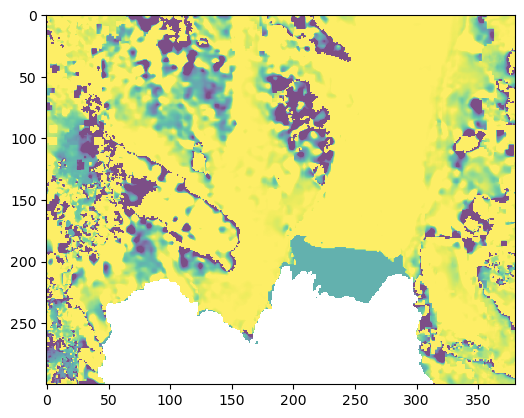

In [223]:
plt.imshow(interpolated_ratios_y.loc[1, 2011][100:400,510:890], cmap='viridis', alpha=0.7, vmin=-1, vmax=1)


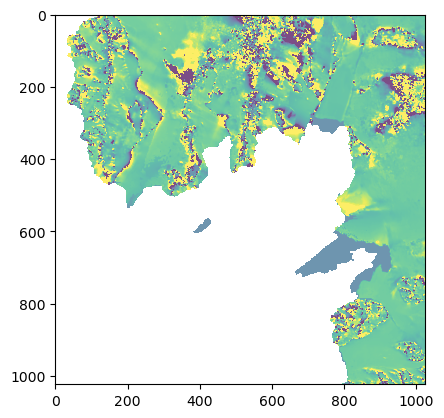

In [224]:
plt.imshow(interpolated_ratios_x.loc[1, 2006], cmap='viridis', alpha=0.7, vmin=-1, vmax=2)

In [225]:
#re-creating the velocity dataset, with holes

velocity_multi_and_single_x = pd.DataFrame(index = df.index, columns = common_years)
velocity_multi_and_single_y = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        #Here we just use the inteporlated images, where the coverage is good
        if coverage_ratio_x.loc[id, year] >= threshold_interpolation:
            velocity_multi_and_single_x.loc[id, year] = interpolated_ice_x.loc[id, year]
            
        if coverage_ratio_x.loc[id, year] < threshold_interpolation:
            velocity_multi_and_single_x.loc[id, year] = interpolated_ratios_x.loc[id, year] * velocity_multy_years_x.loc[id, 'image']

        if coverage_ratio_y.loc[id, year] >= threshold_interpolation:
            velocity_multi_and_single_y.loc[id, year] = interpolated_ice_y.loc[id, year]

        if coverage_ratio_y.loc[id, year] < threshold_interpolation:
            velocity_multi_and_single_y.loc[id, year] = interpolated_ratios_y.loc[id, year] * velocity_multy_years_y.loc[id, 'image']


In [226]:
velocity_multi_and_single = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        velocity_multi_and_single.loc[id, year] = np.sqrt(velocity_multi_and_single_x.loc[id, year]**2 + velocity_multi_and_single_y.loc[id, year]**2)

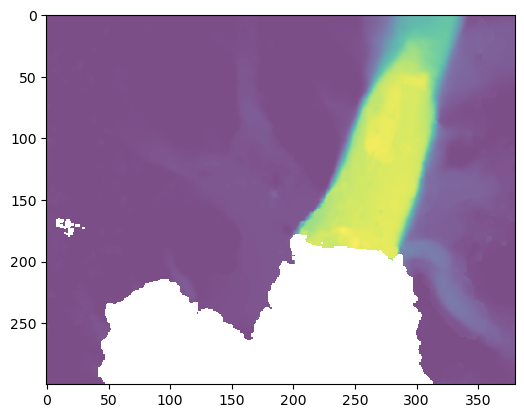

In [227]:
year = 2011
velocity = np.sqrt(velocity_multi_and_single_x.loc[1,year]**2 + velocity_multi_and_single_y.loc[1,year]**2)

plt.imshow(velocity[100:400,510:890], cmap='viridis', alpha=0.7)

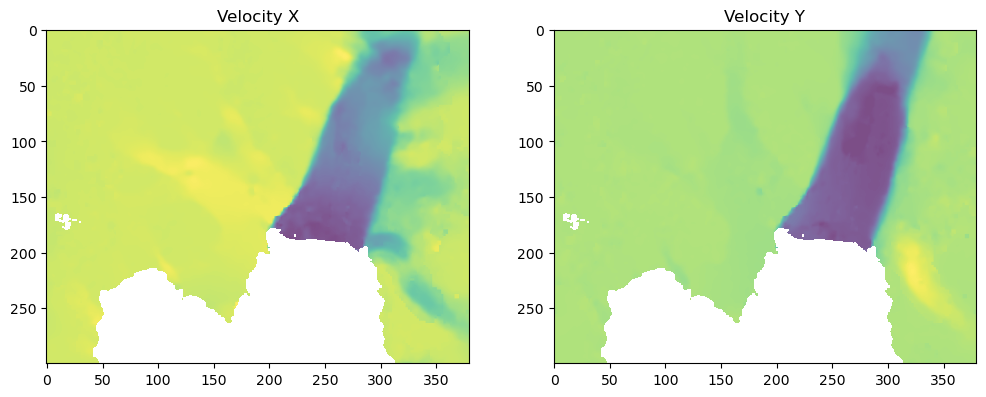

In [228]:
year = 2011
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
#Plot the 2 images
ax[0].imshow(velocity_multi_and_single_x.loc[1,year][100:400,510:890], cmap='viridis', alpha=0.7)
ax[0].set_title('Velocity X')
ax[1].imshow(velocity_multi_and_single_y.loc[1,year][100:400,510:890], cmap='viridis', alpha=0.7)
ax[1].set_title('Velocity Y')

plt.show()


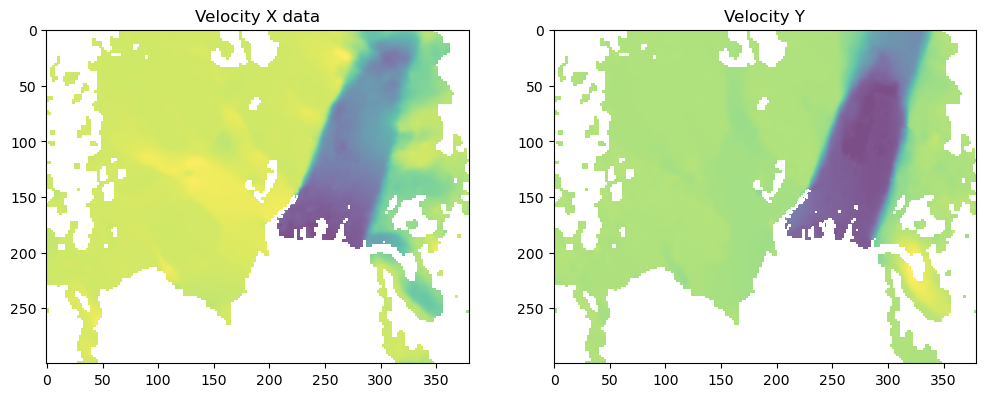

In [229]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
#Plot the 2 images
ax[0].imshow(velocity_x_tif_smoothed.loc[1,year][100:400,510:890], cmap='viridis', alpha=0.7)
ax[0].set_title('Velocity X data')
ax[1].imshow(velocity_y_tif_smoothed.loc[1,year][100:400,510:890], cmap='viridis', alpha=0.7)
ax[1].set_title('Velocity Y')

plt.show()

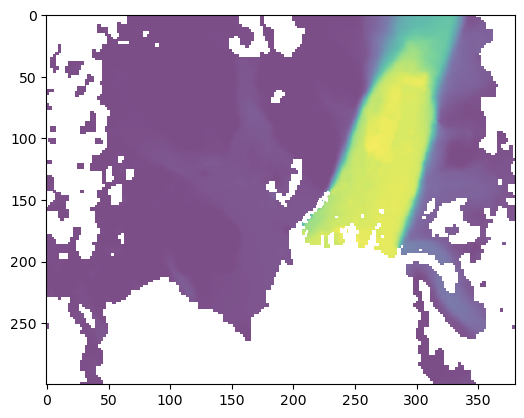

In [234]:
prova = np.sqrt(velocity_x_tif_smoothed.loc[1,year]**2 + velocity_y_tif_smoothed.loc[1,year]**2)

plt.imshow(prova[100:400,510:890], cmap='viridis', alpha=0.7)

In [235]:
#N.B the multy year velocity x and y have the same nans, so we can use the same mask for both.
#This mask presents the regions where we have nan in multi years AND floating ice

green_and_multi = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:

    #To chenge in velocity_multy_years_x.loc[id, 'image']==0 if it has not been set to nan
    mask_nan_in_multi_year = np.isnan(velocity_multy_years_x.loc[id, 'image'])

    for year in common_years:

            #check when velocity_multy_years_x.loc[id, 'image'][ice_mask.loc[id, year]] is 0
            #velocity_01_x.loc[id, year][ice_mask.loc[id, year]] = 0
            green_and_multi.loc[id,year] = np.logical_and(mask_nan_in_multi_year, ice_mask.loc[id, year])


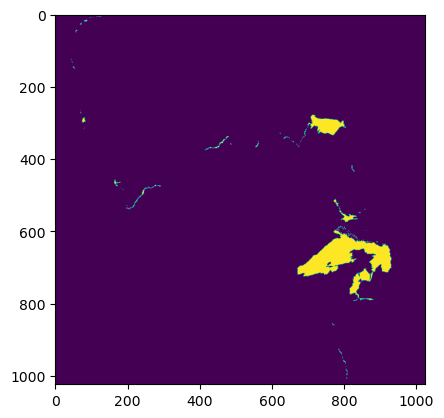

In [236]:
plt.imshow(green_and_multi.loc[1,2008], cmap='viridis')

In [237]:
board = boarders_mask.loc[1, 2008]
ice = ice_mask.loc[1, 2008]

board_ice = np.logical_and(board, ice)


In [243]:
#Cooking Thwaites and PI: I create boarder masks and I calculate the average velocity in the boarders
from scipy import ndimage

# Define the slices for the regions of interest
region1_slice = (slice(280, 401), slice(710, 791))
region2_slice = (slice(580, 741), slice(660,826))

result_mask = np.full_like(board_ice, fill_value=False)

# Extract the regions using the slices
result_mask[region1_slice] = board_ice[region1_slice]
result_mask[region2_slice] = board_ice[region2_slice]

pine_island_boarders_average_x = pd.DataFrame(index = df.index, columns = common_years)
thwaites_boarders_average_x = pd.DataFrame(index = df.index, columns = common_years)

pine_island_boarders_average_y = pd.DataFrame(index = df.index, columns = common_years)
thwaites_boarders_average_y = pd.DataFrame(index = df.index, columns = common_years)

interpo_th_x = []
interpo_th_y = []

pine_island_boarder = pd.DataFrame(index = df.index, columns = common_years)
thwaites_boarders = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        #Here we look at the average velocity in the boarders of the two regions, usign theoriginal data
        pine_island_boarders_average_x.loc[id,year] = np.nanmean(velocity_x_tif_smoothed.loc[id, year][region1_slice])
        thwaites_boarders_average_x.loc[id,year] = np.nanmean(velocity_x_tif_smoothed.loc[id, year][region2_slice])

        pine_island_boarders_average_y.loc[id,year] = np.nanmean(velocity_y_tif_smoothed.loc[id, year][region1_slice])
        thwaites_boarders_average_y.loc[id,year] = np.nanmean(velocity_y_tif_smoothed.loc[id, year][region2_slice])

        interpo_th_x.append(np.nanmean(velocity_x_tif_smoothed.loc[id, year][region2_slice]))
        interpo_th_y.append(np.nanmean(velocity_y_tif_smoothed.loc[id, year][region2_slice]))

        #Here we load the boarders
        board = boarders_mask.loc[id, year]
        ice = ice_mask.loc[id, year]

        #where we have both ice and boarders
        ice_board = np.logical_and(board, ice)

        #creating background for PI and Th
        back_ground_pi = np.full_like(ice, fill_value=False)
        back_ground_th = np.full_like(ice, fill_value=False)

        #The slices for the regions of interest
        back_ground_pi[region1_slice] = ice_board[region1_slice]
        back_ground_th[region2_slice] = ice_board[region2_slice]

        #Expand the boarders of 10 pixels
        #back_ground_pi = ndimage.binary_dilation(back_ground_pi, iterations=iterations)
        #back_ground_th = ndimage.binary_dilation(back_ground_th, iterations=iterations)

        #saving the boarders
        pine_island_boarder.loc[id, year] = back_ground_pi
        thwaites_boarders.loc[id, year] = back_ground_th


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_5725/4121081057.py:31: RuntimeWarning: Mean of empty slice
  thwaites_boarders_average_x.loc[id,year] = np.nanmean(velocity_x_tif_smoothed.loc[id, year][region2_slice])
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_5725/4121081057.py:34: RuntimeWarning: Mean of empty slice
  thwaites_boarders_average_y.loc[id,year] = np.nanmean(velocity_y_tif_smoothed.loc[id, year][region2_slice])
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_5725/4121081057.py:36: RuntimeWarning: Mean of empty slice
  interpo_th_x.append(np.nanmean(velocity_x_tif_smoothed.loc[id, year][region2_slice]))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_5725/4121081057.py:37: RuntimeWarning: Mean of empty slice
  interpo_th_y.append(np.nanmean(velocity_y_tif_smoothed.loc[id, year][region2_slice]))


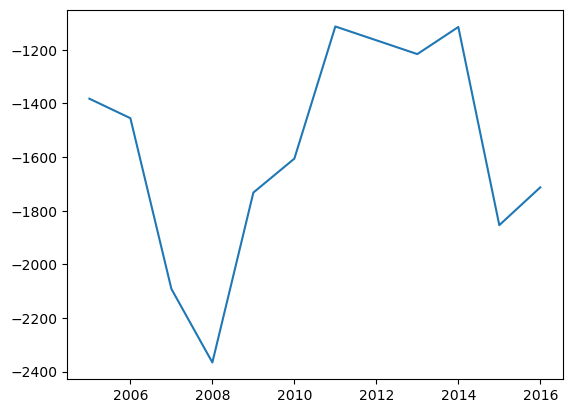

In [246]:
#inteprolate interpo_th

interpo_th_x = np.array(interpo_th_x)
interpo_th_x = interpolation_excluding_extreames(interpo_th_x)

interpo_th_y = np.array(interpo_th_y)
interpo_th_y = interpolation_excluding_extreames(interpo_th_y)

plt.plot(common_years,interpo_th_y)

In [247]:
#Interpolation for x
v_x_final = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        print(year)

        prova = velocity_multi_and_single_x.loc[id, year]
        prova[green_and_multi.loc[id, year]] = np.nan
        prova[thwaites_boarders.loc[id,year]] = thwaites_boarders_average_x.loc[id, year]
        #prova[pine_island_boarder.loc[id,year]] = pine_island_boarders_average_x.loc[id, year]
        mask_nan = np.isnan(prova)
        prova = inpaint.inpaint_biharmonic(prova, mask_nan)
        prova[sea_mask.loc[id, year]] = np.nan           

        v_x_final.loc[id, year] = prova 

2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [253]:
#Interpolation for y
v_y_final = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        print(year)

        prova = velocity_multi_and_single_y.loc[id, year]
        prova[green_and_multi.loc[id, year]] = np.nan
        prova[thwaites_boarders.loc[id,year]] = thwaites_boarders_average_y.loc[id, year]
        #prova[pine_island_boarder.loc[id,year]] = pine_island_boarders_average_x.loc[id, year]
        mask_nan = np.isnan(prova)
        prova = inpaint.inpaint_biharmonic(prova, mask_nan)
        prova[sea_mask.loc[id, year]] = np.nan           

        v_y_final.loc[id, year] = prova 

2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [274]:
#save vx and vy
np.save('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/v_x_final.npy', v_x_final)
np.save('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/v_y_final.npy', v_y_final)

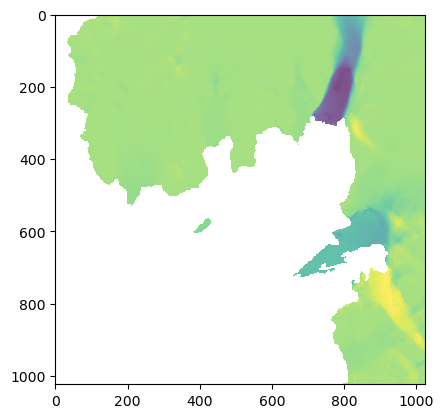

In [258]:
plt.imshow(v_y_final.loc[1, 2011], cmap='viridis', alpha=0.7)

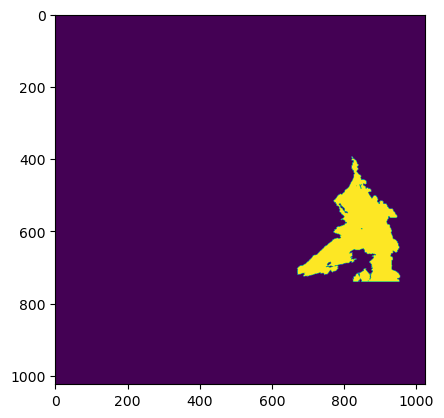

In [259]:
# Here I am looking at Thwaites 

region_th = (slice(380, 741), slice(600, 1001)) #Thwaites

mask_th = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:
        result_mask = np.full_like(ice_mask.loc[id,year], fill_value=False)
        result_mask[region_th] = ice_mask.loc[id,year][region_th]
        mask_th.loc[id, year] = result_mask

        #mask_th.loc[id, year] = thwaites_boarders.loc[id, year]

plt.imshow(mask_th.loc[1,2008], cmap='viridis')

In [260]:
v_x_final_2 = pd.DataFrame(index = df.index, columns = common_years)
v_y_final_2 = pd.DataFrame(index = df.index, columns = common_years)

i = 0
for year in [2011,2012,2013]:
    
    prova = v_x_final.loc[1, year]
    prova[green_and_multi.loc[id, year]] = np.nan
    prova[mask_th.loc[id, year]] = np.nan
    prova[mask_th.loc[id, year]] = velocity_x_tif_smoothed.loc[id, year][mask_th.loc[id, year]]
    prova[thwaites_boarders.loc[id,year]] = interpo_th_x[i]

    mask_nan = np.isnan(prova)
    prova = inpaint.inpaint_biharmonic(prova, mask_nan)
    prova[sea_mask.loc[id, year]] = np.nan

    v_x_final_2.loc[1, year] = prova

    #Same for y

    prova = v_y_final.loc[1, year]
    prova[green_and_multi.loc[id, year]] = np.nan
    prova[mask_th.loc[id, year]] = np.nan
    prova[mask_th.loc[id, year]] = velocity_y_tif_smoothed.loc[id, year][mask_th.loc[id, year]]
    prova[thwaites_boarders.loc[id,year]] = interpo_th_y[i]

    mask_nan = np.isnan(prova)
    prova = inpaint.inpaint_biharmonic(prova, mask_nan)
    prova[sea_mask.loc[id, year]] = np.nan

    v_y_final_2.loc[1, year] = prova

    i = i + 1

In [ ]:
#save vx and vy
np.save('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/v_x_final_2.npy', v_x_final_2)
np.save('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/v_y_final_2.npy', v_y_final_2)

In [261]:
v_x_final_3 = pd.DataFrame(index = df.index, columns = common_years)
v_y_final_3 = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        v_x_final_3.loc[id, year] = v_x_final.loc[id, year]
        v_y_final_3.loc[id, year] = v_y_final.loc[id, year]

        if year == 2011 or year == 2012 or year == 2013:
            v_x_final_3.loc[id, year] = v_x_final_2.loc[id, year]
            v_y_final_3.loc[id, year] = v_y_final_2.loc[id, year]

In [268]:
velocity = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        velocity.loc[id, year] = np.sqrt(v_x_final_3.loc[id, year]**2 + v_y_final_3.loc[id, year]**2)

In [267]:
#Save the final velocity dataset
#np.save('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/v_x_final.npy', v_x_final_3)
#np.save('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/v_y_final.npy', v_y_final_3)

In [273]:
plot_images_to_pdf(velocity_y_tif_smoothed,'v_y_dataset', common_years)



<font size="5">Calculate the coverage ratio for each region and each year for the not floating ice</font>

In [86]:
#Now calculate the coverage ratio for each region.

coverage_no_nan_v_x_grounded = pd.DataFrame(index = df.index, columns = common_years)
coverage_no_nan_v_y_grounded = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        #This takes the number of the NOT A NAN nan pixels in the region which is not sea,
        #divided by the total number of pixels which are not sea.

        #mask_grounded = np.logical_or(grounded_ice_mask.loc[id, year], land_mask.loc[id,year])
        mask_grounded = ~sea_mask.loc[id, year] #NEW VERSION

        coverage_no_nan_v_x_grounded.loc[id, year] = np.sum(~np.isnan(velocity_x_tif_smoothed.loc[id, year][mask_grounded])) / np.sum(mask_grounded)
        coverage_no_nan_v_y_grounded.loc[id, year] = np.sum(~np.isnan(velocity_y_tif_smoothed.loc[id, year][mask_grounded])) / np.sum(mask_grounded)


NO, IS DIFFERENT!
Here i calculate the rescaling ratio: EVERYTHING WILL NEED TO BE REDONE IN Y
- If coverage < 0.3 : take multi year without rescaling
- If 0.3 < coverage < 0.70: rescale the multi year
- If coverage > 0.70 interpolate

In [89]:
print(coverage_no_nan_v_y_grounded.loc[1])
print(coverage_no_nan_v_x_grounded.loc[1])

2005    0.457831
2006    0.324942
2007    0.719423
2008    0.791718
2009    0.576226
2010     0.71099
2011    0.478905
2012    0.275112
2013     0.91407
2014    0.947456
2015    0.767144
2016    0.925146
Name: 1, dtype: object
2005    0.457929
2006    0.325308
2007    0.719449
2008    0.791665
2009    0.576205
2010    0.710896
2011    0.478989
2012    0.275146
2013    0.913964
2014    0.947315
2015    0.767209
2016    0.925112
Name: 1, dtype: object


In [13]:
#Now we look at the coverage and according to this we intepolate or not (5 mins per region)

from skimage.restoration import inpaint

interpo_x = pd.DataFrame(index = df.index, columns = common_years)

threshold_interpolation = 0.70

for id in df.index:
    for year in common_years:

        print(year)

        if coverage_no_nan_v_x_grounded.loc[id, year]  > threshold_interpolation:

            mask_nan = np.isnan(velocity_x_tif_smoothed.loc[id, year])
            interpo_x.loc[id, year] = inpaint.inpaint_biharmonic(velocity_x_tif_smoothed.loc[id, year], mask_nan)
            interpo_x.loc[id, year][sea_mask.loc[id, year]] = np.nan


2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [90]:
interpo_y = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        print(year)

        if coverage_no_nan_v_y_grounded.loc[id, year]  > threshold_interpolation:

            mask_nan = np.isnan(velocity_y_tif_smoothed.loc[id, year])
            interpo_y.loc[id, year] = inpaint.inpaint_biharmonic(velocity_y_tif_smoothed.loc[id, year], mask_nan)
            interpo_y.loc[id, year][sea_mask.loc[id, year]] = np.nan
            

2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [91]:
#Check for nan values

for id in df.index:
    for year in common_years:

        if coverage_no_nan_v_y_grounded.loc[id, year]  > threshold_interpolation:

            no_sea = ~sea_mask.loc[id, year]
            count_nan = np.sum(np.isnan(interpo_y.loc[id, year][no_sea]))
            print('Region: ', id, 'Year: ', year, 'Count nan: ', count_nan)

Region:  1 Year:  2007 Count nan:  0
Region:  1 Year:  2008 Count nan:  0
Region:  1 Year:  2010 Count nan:  0
Region:  1 Year:  2013 Count nan:  0
Region:  1 Year:  2014 Count nan:  0
Region:  1 Year:  2015 Count nan:  0
Region:  1 Year:  2016 Count nan:  0


In [92]:
#here we Calcualtate the ratios

ratios_x = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        if coverage_no_nan_v_x_grounded.loc[id, year]  > threshold_interpolation:
            ratios_x.loc[id, year] = interpo_x.loc[id, year] / velocity_multy_years_x.loc[id, 'image']

        else:    
            ratios_x.loc[id, year] = velocity_x_tif_smoothed.loc[id, year] / velocity_multy_years_x.loc[id, 'image']


#Now I set to 0 all the values which are not in the see but nan. 
#Because in the multi year velocity we have 0 values not in the sea,
#and the ratio is ofcourse impossible to calculate
for id in df.index:
    for year in common_years:

        if coverage_no_nan_v_x_grounded.loc[id, year]  > threshold_interpolation:
  
            mask_nan_and_not_sea = np.logical_and(~sea_mask.loc[id, year], np.isnan(ratios_x.loc[id, year]))
            ratios_x.loc[id, year][mask_nan_and_not_sea] = 0


#Same for y
ratios_y = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        if coverage_no_nan_v_y_grounded.loc[id, year]  > threshold_interpolation:
            ratios_y.loc[id, year] = interpo_y.loc[id, year] / velocity_multy_years_y.loc[id, 'image']

        else:    
            ratios_y.loc[id, year] = velocity_y_tif_smoothed.loc[id, year] / velocity_multy_years_y.loc[id, 'image']

for id in df.index:
    for year in common_years:

        if coverage_no_nan_v_y_grounded.loc[id, year]  > threshold_interpolation:
  
            mask_nan_and_not_sea = np.logical_and(~sea_mask.loc[id, year], np.isnan(ratios_y.loc[id, year]))
            ratios_y.loc[id, year][mask_nan_and_not_sea] = 0

        

/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_8944/2795129974.py:37: RuntimeWarning: divide by zero encountered in divide
  ratios_y.loc[id, year] = velocity_y_tif_smoothed.loc[id, year] / velocity_multy_years_y.loc[id, 'image']
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_8944/2795129974.py:34: RuntimeWarning: divide by zero encountered in divide
  ratios_y.loc[id, year] = interpo_y.loc[id, year] / velocity_multy_years_y.loc[id, 'image']


In [94]:
#Check for nan values in the ratio dataset in the no_sea_region

for id in df.index:
    for year in common_years:

        no_sea = ~sea_mask.loc[id, year]
        count_nan = np.sum(np.isnan(ratios_x.loc[id, year][no_sea]))
        print('Region: ', id, 'Year: ', year, 'Count nan: ', count_nan)

Region:  1 Year:  2005 Count nan:  291362
Region:  1 Year:  2006 Count nan:  363636
Region:  1 Year:  2007 Count nan:  0
Region:  1 Year:  2008 Count nan:  0
Region:  1 Year:  2009 Count nan:  229355
Region:  1 Year:  2010 Count nan:  0
Region:  1 Year:  2011 Count nan:  279076
Region:  1 Year:  2012 Count nan:  381707
Region:  1 Year:  2013 Count nan:  0
Region:  1 Year:  2014 Count nan:  0
Region:  1 Year:  2015 Count nan:  0
Region:  1 Year:  2016 Count nan:  0


In [95]:
#looking at some values to understand if later i reshaped well. Is working
for id in df.index:
    for year in common_years:

        print(ratios_y.loc[id, year][10,162])

nan
nan
1.0719123
0.9863573
nan
0.9649351
nan
nan
1.1353359
1.0627164
0.9844913
1.1993809


From Here on we will do the interpolation pixel by pixel

In [96]:
#Reshaping the data
#the array indeces are (ice shelf, pixel, time)

raveled_vector_x = np.zeros((len(df.index),len(ratios_x.loc[id, year].ravel()), len(common_years))) 

index = 0
for id in df.index:

    time = 0

    for year in common_years:

        matrix = ratios_x.loc[id, year]
        array_raveled = matrix.ravel()
        raveled_vector_x[index, :,time] = array_raveled
        time = time + 1

    index = index + 1


#Redoing it for y
raveled_vector_y = np.zeros((len(df.index),len(ratios_y.loc[id, year].ravel()), len(common_years)))
index = 0

for id in df.index:
        
        time = 0
    
        for year in common_years:
    
            matrix = ratios_y.loc[id, year]
            array_raveled = matrix.ravel()
            raveled_vector_y[index, :,time] = array_raveled
            time = time + 1
    
        index = index + 1


In [41]:
#Function to make the interpolation

def interpolation_excluding_extreames(A):

    A = np.array(A)

    x = np.interp(np.arange(len(A)), 
            np.arange(len(A))[np.isnan(A) == False], 
            A[np.isnan(A) == False])

    if np.isnan(A[0]) == True:
        x[0] = A[0]
        if np.isnan(A[1]) == True:
            x[1] = A[1]
            if np.isnan(A[2]) == True:
                x[2] = A[2]
                if np.isnan(A[3]) == True:
                    x[3] = A[3]

    if np.isnan(A[-1]) == True:
        x[-1] = A[-1]
        if np.isnan(A[-2]) == True:
            x[-2] = A[-2]
            if np.isnan(A[-3]) == True:
                x[-3] = A[-3]
                if np.isnan(A[-4]) == True:
                    x[-4] = A[-4]

    return x



In [42]:
def fill_fist_values(A):

    A = np.array(A)

    for i in range(len(A)):

        if np.isnan(A[i]) == False:
            A[:i] = A[i]
            break

    return A

In [99]:
#Example
x = [5,np.nan,3,4,5.5,np.nan,np.nan,np.nan,10,10,np.nan,16,13,14,15]

y = fill_fist_values(x)

print(y)

[ 5.   nan  3.   4.   5.5  nan  nan  nan 10.  10.   nan 16.  13.  14.
 15. ]


In [100]:
#step by step interpolation  x

for i in range(len(df.index)): #for each region
   for j in range(len(ratios_x.loc[id, year].ravel())): #for each pixel of the region

      #take the values of the pixel
      x = raveled_vector_x[i, j, :] #here I am taking the ratio time serie for each pixel

      #If the value is all nan, skip to the next pixel
      if np.isnan(x).all() == True:
          continue

      #interpolate the nan values as the average of the two closest values
      x = interpolation_excluding_extreames(x)

      x = fill_fist_values(x)

      raveled_vector_x[i, j, :] = x

#step by step interpolation  y
      
for i in range(len(df.index)): #for each region
   for j in range(len(ratios_y.loc[id, year].ravel())): #for each pixel of the region

      #take the values of the pixel
      y = raveled_vector_y[i, j, :] #here I am taking the ratio time serie for each pixel

      #If the value is all nan, skip to the next pixel
      if np.isnan(y).all() == True:
          continue

      #interpolate the nan values as the average of the two closest values
      y = interpolation_excluding_extreames(y)

      y = fill_fist_values(y)

      raveled_vector_y[i, j, :] = y

(2004.0, 2017.0)

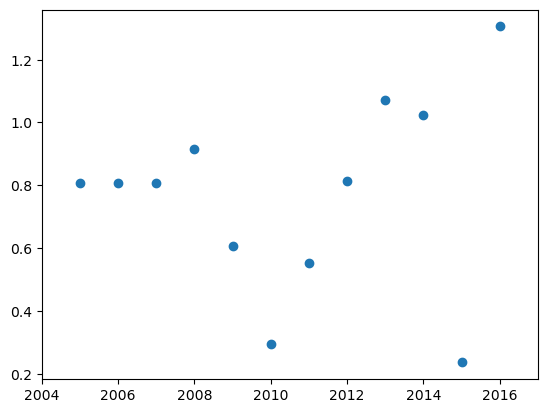

In [101]:
plt.scatter(common_years,raveled_vector_y[0, 455, :])
#Set axis bounds
plt.xlim(2004,2017)

In [25]:
# #Check if i removed all the nan values
# for i in range(len(df.index)):
#     for j in range(len(ratios.loc[id, year].ravel())):

#         if np.isnan(raveled_vector[i, j, :]).any() == True:
#             print('Region: ', i, 'Pixel: ', j)


In [26]:
#now we perform the linear regression for each pixel (2 mins maximum)

#linear_coeffs = np.zeros((len(df.index),len(ratios.loc[id, year].ravel()), 2))

# for i in range(len(df.index)): #for each region
#     for j in range(len(ratios.loc[id, year].ravel())): #for each pixel of the region

#         #take the values of the pixel
#         y = raveled_vector[i, j, :] #here I am taking the ratio time serie for each pixel
#         x = common_years

#         #exclude the nan values
#         mask = ~np.isnan(y)
#         y = y[mask]
#         x = x[mask]

#         #perform the linear regression
#         A = np.vstack([x, np.ones(len(x))]).T
#         m, c = np.linalg.lstsq(A, y, rcond=None)[0] #m is linear cooefficint, c is the constant

#         linear_coeffs[i, j, 0] = m
#         linear_coeffs[i, j, 1] = c

#substitute the nan values with the linear regression #RUN ONLY ONCE

# for i in range(len(df.index)):
#     for j in range(len(ratios.loc[id, year].ravel())):

#         mask = np.isnan(raveled_vector[i, j, :])
#         raveled_vector[i, j, mask] = linear_coeffs[i, j, 0] * common_years[mask] + linear_coeffs[i, j, 1]


In [102]:
#Re organising the interpolated ratio dataset

interpolated_ratios_x = pd.DataFrame(index = df.index, columns = common_years)

index_raveled = 0

for id in df.index:

    time = 0

    for year in common_years:

        matrix = raveled_vector_x[index_raveled, :, time].reshape(velocity_multy_years_x.loc[id, 'image'].shape)
        interpolated_ratios_x.loc[id, year] = matrix
        time = time + 1

    index_raveled = index_raveled + 1



#redoing it for y
interpolated_ratios_y = pd.DataFrame(index = df.index, columns = common_years)

index_raveled = 0

for id in df.index:

    time = 0

    for year in common_years:

        matrix = raveled_vector_y[index_raveled, :, time].reshape(velocity_multy_years_y.loc[id, 'image'].shape)
        interpolated_ratios_y.loc[id, year] = matrix
        time = time + 1

    index_raveled = index_raveled + 1


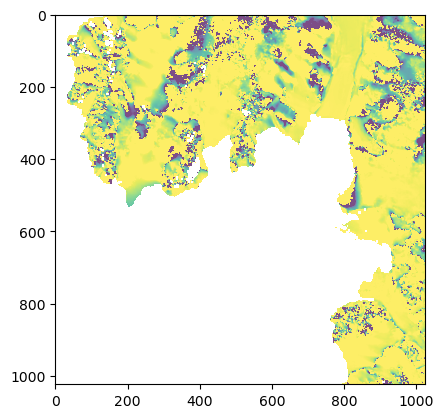

In [104]:
plt.imshow(interpolated_ratios_y.loc[1, 2007], cmap='viridis', alpha=0.7, vmin=-1, vmax=1)


In [113]:
#re-creating the velocity dataset, with holes

velocity_multi_and_single_x = pd.DataFrame(index = df.index, columns = common_years)
velocity_multi_and_single_y = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        #Here we just use the inteporlated images, where the coverage is good
        if coverage_no_nan_v_x_grounded.loc[id, year] >= threshold_interpolation:
            velocity_multi_and_single_x.loc[id, year] = interpo_x.loc[id, year]
            
        if coverage_no_nan_v_x_grounded.loc[id, year] < threshold_interpolation:
            velocity_multi_and_single_x.loc[id, year] = interpolated_ratios_x.loc[id, year] * velocity_multy_years_x.loc[id, 'image']

        if coverage_no_nan_v_y_grounded.loc[id, year] >= threshold_interpolation:
            velocity_multi_and_single_y.loc[id, year] = interpo_y.loc[id, year]

        if coverage_no_nan_v_y_grounded.loc[id, year] < threshold_interpolation:
            velocity_multi_and_single_y.loc[id, year] = interpolated_ratios_y.loc[id, year] * velocity_multy_years_y.loc[id, 'image']


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_8944/2329677333.py:20: RuntimeWarning: invalid value encountered in multiply
  velocity_multi_and_single_y.loc[id, year] = interpolated_ratios_y.loc[id, year] * velocity_multy_years_y.loc[id, 'image']


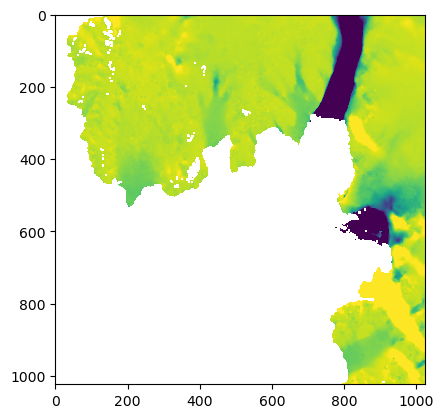

In [116]:
plt.imshow(velocity_multi_and_single_y.loc[1, 2012], cmap='viridis', vmin=-1000, vmax=100)

In [119]:
#Now we put the values of the single years where the multi year velocity is lacking

velocity_multi_and_single_x_2 = velocity_multi_and_single_x.copy()
velocity_multi_and_single_y_2 = velocity_multi_and_single_y.copy()

for id in df.index:
    for year in common_years:

        if coverage_no_nan_v_x_grounded.loc[id, year]  < threshold_interpolation:

            mask_nan = np.isnan(velocity_multi_and_single_x.loc[id, year]) # This is the mask where in the low coverage we have nan values
            mask_not_a_nan_in_single_year = ~np.isnan(velocity_x_tif_smoothed.loc[id, year]) #
            combined_mask = np.logical_and(mask_nan, mask_not_a_nan_in_single_year)

            velocity_multi_and_single_x_2.loc[id, year][combined_mask] = velocity_x_tif_smoothed.loc[id, year][combined_mask]

        if coverage_no_nan_v_y_grounded.loc[id, year]  < threshold_interpolation:

            mask_nan = np.isnan(velocity_multi_and_single_y.loc[id, year])
            mask_not_a_nan_in_single_year = ~np.isnan(velocity_y_tif_smoothed.loc[id, year])
            combined_mask = np.logical_and(mask_nan, mask_not_a_nan_in_single_year)

            velocity_multi_and_single_y_2.loc[id, year][combined_mask] = velocity_y_tif_smoothed.loc[id, year][combined_mask]


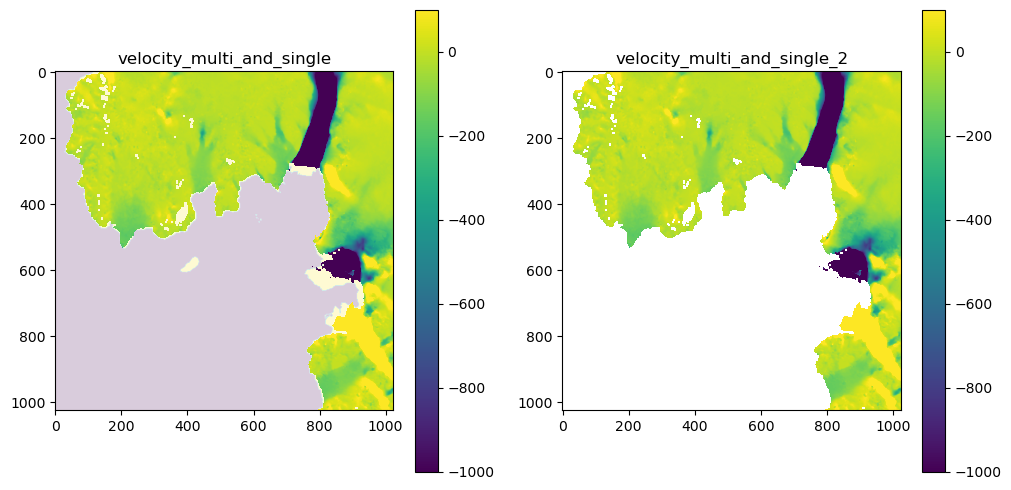

In [137]:
year = 2012

figs, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(velocity_multi_and_single_y_2.loc[1, year], cmap='viridis', vmin=-1000, vmax=100, alpha=0.7)
axes[0].imshow(~sea_mask.loc[1, year], cmap='viridis', alpha=0.2)
axes[0].set_title('velocity_multi_and_single')
#add colorbar
cbar = plt.colorbar(axes[0].imshow(velocity_multi_and_single_y_2.loc[1, year], cmap='viridis', vmin=-1000, vmax=100), ax=axes[0])

axes[1].imshow(velocity_multi_and_single_y_2.loc[1, year], cmap='viridis', vmin=-1000, vmax=100)
axes[1].set_title('velocity_multi_and_single_2')
#add colorbar
cbar = plt.colorbar(axes[1].imshow(velocity_multi_and_single_y_2.loc[1, year], cmap='viridis', vmin=-1000, vmax=100), ax=axes[1])

In [33]:
coverage_no_nan_v_x_grounded

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
1,0.457929,0.325308,0.719449,0.791665,0.576205,0.710896,0.478989,0.275146,0.913964,0.947315,0.767209,0.925112


In [121]:
coverage_no_nan_v_y_grounded

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
1,0.457831,0.324942,0.719423,0.791718,0.576226,0.71099,0.478905,0.275112,0.91407,0.947456,0.767144,0.925146


Here i will check possibilities for thwaites and Pine Island

In [126]:
board = boarders_mask.loc[1, 2008]
ice = ice_mask.loc[1, 2008]

board_ice = np.logical_and(board, ice)


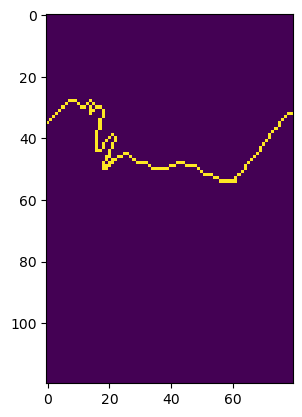

In [127]:
plt.imshow(board_ice[280:400,710:790], cmap='viridis')

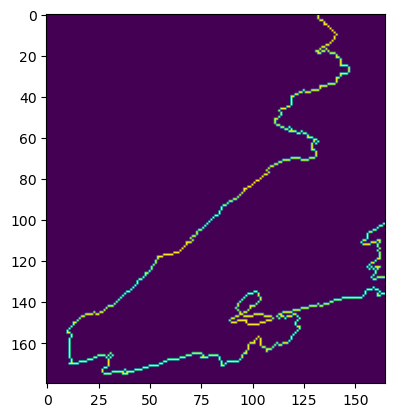

In [128]:
plt.imshow(board_ice[550:730,660:825], cmap='viridis')

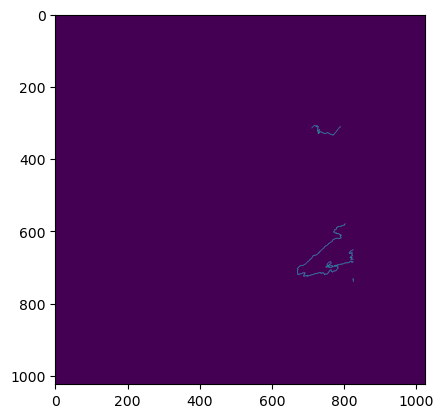

In [129]:
# Define the slices for the regions of interest
region1_slice = (slice(280, 401), slice(710, 791))
region2_slice = (slice(580, 741), slice(660,826))

result_mask = np.full_like(board_ice, fill_value=False)

# Extract the regions using the slices
result_mask[region1_slice] = board_ice[region1_slice]
result_mask[region2_slice] = board_ice[region2_slice]

plt.imshow(result_mask, cmap='viridis')


In [138]:
#N.B the multy year velocity x and y have the same nans, so we can use the same mask for both.
#This mask presents the regions where we have nan in multi years AND floating ice

green_and_multi = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:

    #To chenge in velocity_multy_years_x.loc[id, 'image']==0 if it has not been set to nan
    mask_nan_in_multi_year = np.isnan(velocity_multy_years_x.loc[id, 'image'])

    for year in common_years:

            #check when velocity_multy_years_x.loc[id, 'image'][ice_mask.loc[id, year]] is 0
            #velocity_01_x.loc[id, year][ice_mask.loc[id, year]] = 0
            green_and_multi.loc[id,year] = np.logical_and(mask_nan_in_multi_year, ice_mask.loc[id, year])

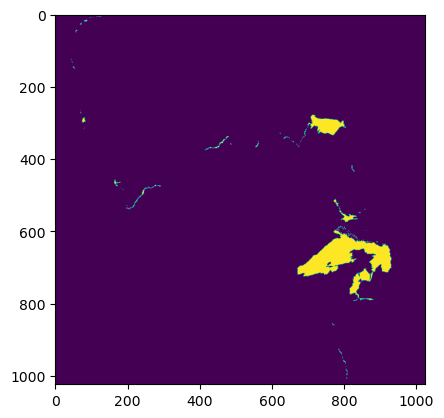

In [253]:
plt.imshow(green_and_multi.loc[1,2008], cmap='viridis')

In [140]:
#Cooking Thwaites and PI
from scipy import ndimage

# Define the slices for the regions of interest
region1_slice = (slice(280, 401), slice(710, 791))
region2_slice = (slice(580, 741), slice(660,826))

result_mask = np.full_like(board_ice, fill_value=False)

# Extract the regions using the slices
result_mask[region1_slice] = board_ice[region1_slice]
result_mask[region2_slice] = board_ice[region2_slice]

pine_island_boarders_average_x = pd.DataFrame(index = df.index, columns = common_years)
thwaites_boarders_average_x = pd.DataFrame(index = df.index, columns = common_years)

pine_island_boarders_average_y = pd.DataFrame(index = df.index, columns = common_years)
thwaites_boarders_average_y = pd.DataFrame(index = df.index, columns = common_years)

interpo_th_x = []
interpo_th_y = []

pine_island_boarder = pd.DataFrame(index = df.index, columns = common_years)
thwaites_boarders = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        #Here we look at the average velocity in the boarders of the two regions, usign the year velcoiuty dataset
        pine_island_boarders_average_x.loc[id,year] = np.nanmean(velocity_x_tif_smoothed.loc[id, year][region1_slice])
        thwaites_boarders_average_x.loc[id,year] = np.nanmean(velocity_x_tif_smoothed.loc[id, year][region2_slice])

        pine_island_boarders_average_y.loc[id,year] = np.nanmean(velocity_y_tif_smoothed.loc[id, year][region1_slice])
        thwaites_boarders_average_y.loc[id,year] = np.nanmean(velocity_y_tif_smoothed.loc[id, year][region2_slice])

        interpo_th_x.append(np.nanmean(velocity_x_tif_smoothed.loc[id, year][region2_slice]))
        interpo_th_y.append(np.nanmean(velocity_y_tif_smoothed.loc[id, year][region2_slice]))

        #Here we load the boarders
        board = boarders_mask.loc[id, year]
        ice = ice_mask.loc[id, year]

        #where we have both ice and boarders
        ice_board = np.logical_and(board, ice)

        #creating background for PI and Th
        back_ground_pi = np.full_like(ice, fill_value=False)
        back_ground_th = np.full_like(ice, fill_value=False)

        #The slices for the regions of interest
        back_ground_pi[region1_slice] = ice_board[region1_slice]
        back_ground_th[region2_slice] = ice_board[region2_slice]

        #Expand the boarders of 10 pixels
        #back_ground_pi = ndimage.binary_dilation(back_ground_pi, iterations=iterations)
        #back_ground_th = ndimage.binary_dilation(back_ground_th, iterations=iterations)

        #saving the boarders
        pine_island_boarder.loc[id, year] = back_ground_pi
        thwaites_boarders.loc[id, year] = back_ground_th


/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_8944/2451265422.py:31: RuntimeWarning: Mean of empty slice
  thwaites_boarders_average_x.loc[id,year] = np.nanmean(velocity_x_tif_smoothed.loc[id, year][region2_slice])
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_8944/2451265422.py:34: RuntimeWarning: Mean of empty slice
  thwaites_boarders_average_y.loc[id,year] = np.nanmean(velocity_y_tif_smoothed.loc[id, year][region2_slice])
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_8944/2451265422.py:36: RuntimeWarning: Mean of empty slice
  interpo_th_x.append(np.nanmean(velocity_x_tif_smoothed.loc[id, year][region2_slice]))
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_8944/2451265422.py:37: RuntimeWarning: Mean of empty slice
  interpo_th_y.append(np.nanmean(velocity_y_tif_smoothed.loc[id, year][region2_slice]))


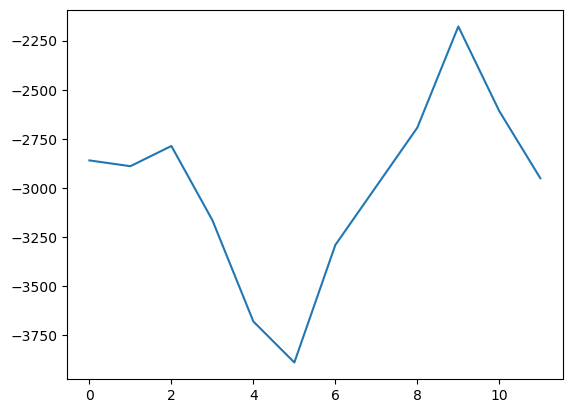

In [142]:
#inteprolate interpo_th

interpo_th_x = np.array(interpo_th_x)
interpo_th_x = interpolation_excluding_extreames(interpo_th_x)

interpo_th_y = np.array(interpo_th_y)
interpo_th_y = interpolation_excluding_extreames(interpo_th_y)

plt.plot(interpo_th_x)

In [42]:
#Interpolation for x
v_x_final = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        print(year)

        prova = velocity_multi_and_single_x_2.loc[id, year]
        prova[green_and_multi.loc[id, year]] = np.nan
        prova[thwaites_boarders.loc[id,year]] = thwaites_boarders_average_x.loc[id, year]
        #prova[pine_island_boarder.loc[id,year]] = pine_island_boarders_average_x.loc[id, year]
        mask_nan = np.isnan(prova)
        prova = inpaint.inpaint_biharmonic(prova, mask_nan)
        prova[sea_mask.loc[id, year]] = np.nan           

        v_x_final.loc[id, year] = prova 

2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [143]:
#interpolation for y

v_y_final = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        print(year)

        prova = velocity_multi_and_single_y_2.loc[id, year]
        prova[green_and_multi.loc[id, year]] = np.nan
        prova[thwaites_boarders.loc[id,year]] = thwaites_boarders_average_y.loc[id, year]
        #prova[pine_island_boarder.loc[id,year]] = pine_island_boarders_average_y.loc[id, year]
        mask_nan = np.isnan(prova)
        prova = inpaint.inpaint_biharmonic(prova, mask_nan)
        prova[sea_mask.loc[id, year]] = np.nan           

        v_y_final.loc[id, year] = prova



2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


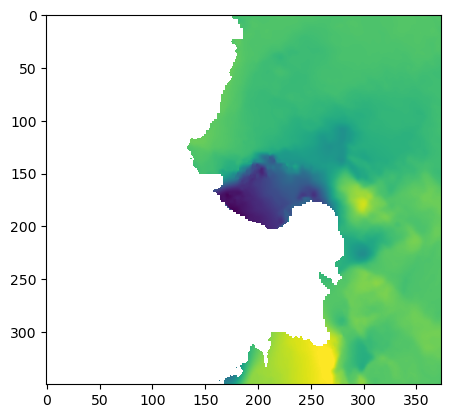

In [164]:
plt.imshow(v_y_final.loc[1,2013][400:750, 650:1500], cmap='viridis')

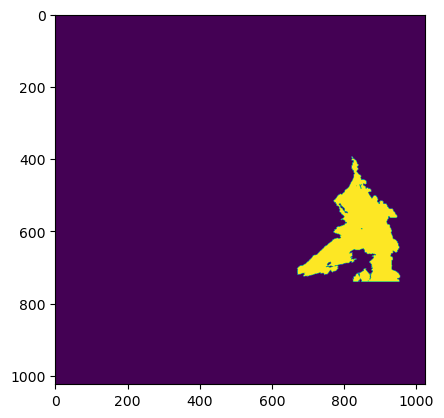

In [160]:
# Here I am looking at Thwaites 

region_th = (slice(380, 741), slice(600, 1001)) #Thwaites

mask_th = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:
        result_mask = np.full_like(ice_mask.loc[id,year], fill_value=False)
        result_mask[region_th] = ice_mask.loc[id,year][region_th]
        mask_th.loc[id, year] = result_mask

        #mask_th.loc[id, year] = thwaites_boarders.loc[id, year]

plt.imshow(mask_th.loc[1,2008], cmap='viridis')

In [197]:
#Specifical for Thwaites 2011,  2012 and 2013

v_x_final_2 = pd.DataFrame(index = df.index, columns = common_years)
v_y_final_2 = pd.DataFrame(index = df.index, columns = common_years)

i = 0
for year in [2011,2012,2013]:
    
    prova = v_x_final.loc[1, year]
    prova[green_and_multi.loc[id, year]] = np.nan
    prova[mask_th.loc[id, year]] = np.nan
    prova[mask_th.loc[id, year]] = velocity_x_tif_smoothed.loc[id, year][mask_th.loc[id, year]]
    prova[thwaites_boarders.loc[id,year]] = interpo_th_x[i]

    mask_nan = np.isnan(prova)
    prova = inpaint.inpaint_biharmonic(prova, mask_nan)
    prova[sea_mask.loc[id, year]] = np.nan

    v_x_final_2.loc[1, year] = prova

    #Same for y

    prova = v_y_final.loc[1, year]
    prova[green_and_multi.loc[id, year]] = np.nan
    prova[mask_th.loc[id, year]] = np.nan
    prova[mask_th.loc[id, year]] = velocity_y_tif_smoothed.loc[id, year][mask_th.loc[id, year]]
    prova[thwaites_boarders.loc[id,year]] = interpo_th_y[i]

    mask_nan = np.isnan(prova)
    prova = inpaint.inpaint_biharmonic(prova, mask_nan)
    prova[sea_mask.loc[id, year]] = np.nan

    v_y_final_2.loc[1, year] = prova

    i = i + 1


TypeError: 'float' object is not subscriptable

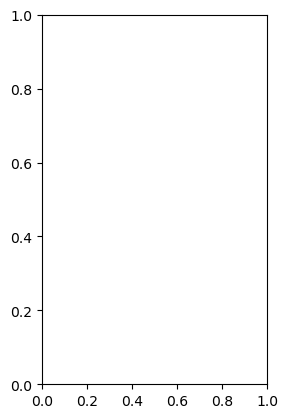

In [241]:

#[150:400, 610:900]
#[400:750, 650:1500]

year = 2014
plt.subplot(1, 2, 1)
# Plot the first image
plt.imshow(v_y_final_2.loc[1, year][150:400, 610:900], cmap='viridis')
plt.title('Image 1')
#cbar = plt.colorbar()

# Create the second subplot
plt.subplot(1, 2, 2)
# Plot the second image
plt.imshow(v_x_final_2.loc[1, year][150:400, 610:900], cmap='viridis',)
#plt.imshow(thwaites_boarders.loc[1, year][400:750, 650:1500], cmap='viridis',alpha = 0.3)
plt.title('Image 2')

# Adjust layout to prevent clipping of titles and labels
plt.tight_layout()

# Show the plot
plt.show()



In [242]:
v_x_final_3 = pd.DataFrame(index = df.index, columns = common_years)
v_y_final_3 = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        v_x_final_3.loc[id, year] = v_x_final.loc[id, year]
        v_y_final_3.loc[id, year] = v_y_final.loc[id, year]

        if year == 2011 or year == 2012 or year == 2013:
            v_x_final_3.loc[id, year] = v_x_final_2.loc[id, year]
            v_y_final_3.loc[id, year] = v_y_final_2.loc[id, year]
   

In [243]:
#save the dataset as a numpy array
#np.save('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/v_x_final_3.npy', v_x_final_3)
#np.save('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/v_y_final_3.npy', v_y_final_3)

#load the dataset
v_x_final_3 = np.load('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/v_x_final_3.npy', allow_pickle=True)
v_x_final_3 = pd.DataFrame(v_x_final_3, index=df.index, columns=common_years)

v_y_final_3 = np.load('/Users/francesco/Desktop/machine_learning_calving_project/dataset_cnn/v_y_final_3.npy', allow_pickle=True)
v_y_final_3 = pd.DataFrame(v_y_final_3, index=df.index, columns=common_years)


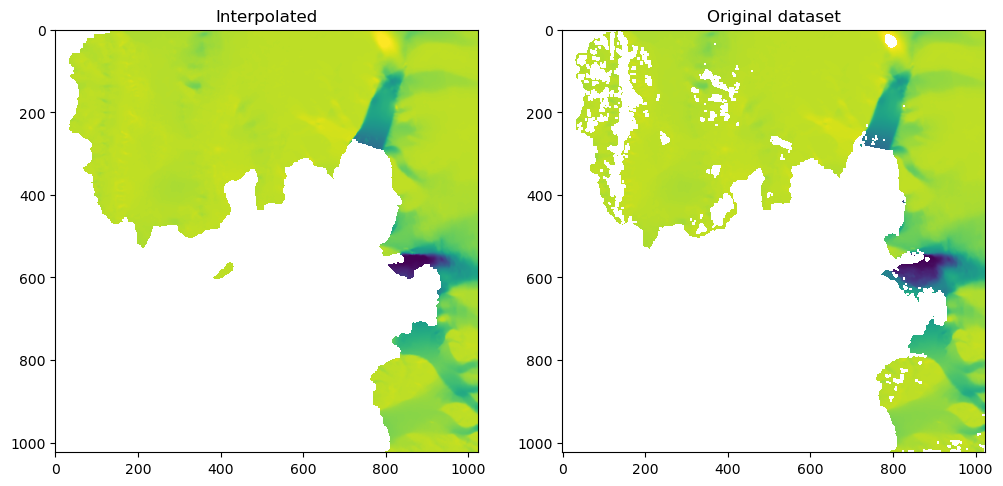

In [245]:
year = 2014

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the first image
axes[0].imshow(v_x_final_3.loc[1, year], cmap='viridis')
axes[0].set_title('Interpolated')

# Plot the second image
axes[1].imshow(velocity_x_tif_smoothed.loc[1, year], cmap='viridis')
axes[1].set_title('Original dataset')

plt.show()


Now I will look at Pine Island

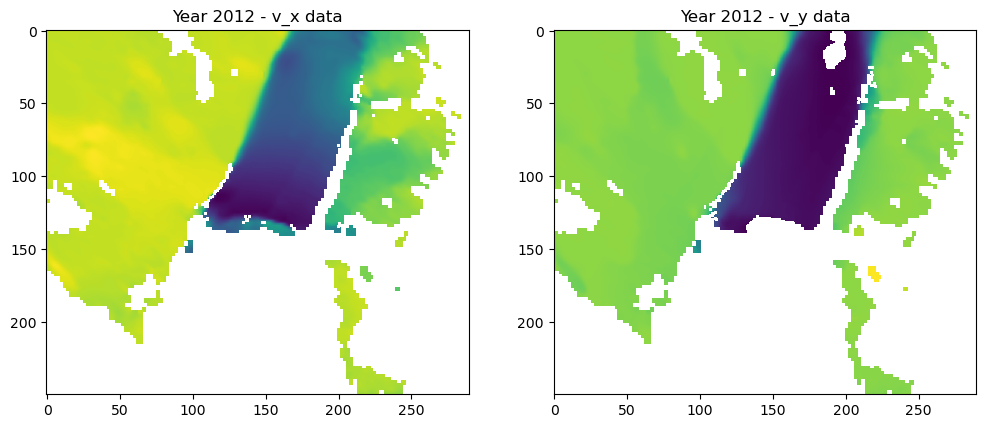

In [246]:
import matplotlib.pyplot as plt

year = 2012
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
#[150:400, 610:900]
#[250:300, 710:800]

# Plot the first image
axes[0].imshow(velocity_x_tif_smoothed.loc[1, year][150:400, 610:900], cmap='viridis')
#Add colorbar
#cbar = plt.colorbar(axes[0].imshow(v_x_final_3.loc[1, year][150:400, 610:800], cmap='viridis', vmin = -1000, vmax = 100), ax=axes[0])
#cbar.set_label('Velocity (m/yr)')
axes[0].set_title(f'Year {year} - v_x data')

# Plot the second image with some transparency (alpha parameter)
axes[1].imshow(velocity_y_tif_smoothed.loc[1, year][150:400, 610:900], cmap='viridis')
#Add colorbar
#cbar = plt.colorbar(axes[1].imshow(velocity_x_tif_smoothed.loc[1, year][150:400, 610:800], cmap='viridis', alpha=0.7, vmin = -1000, vmax = 100), ax=axes[1])
#cbar.set_label('Velocity (m/yr)')
axes[1].set_title(f'Year {year} - v_y data')

plt.show()


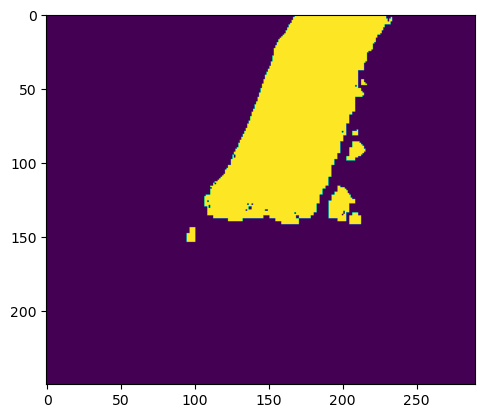

In [67]:
year = 2012

percentile_20 = np.nanpercentile(velocity_x_tif_smoothed.loc[1, year][150:400, 610:900], 25)

low_values_flags = velocity_x_tif_smoothed.loc[id,year][150:400, 610:900] < percentile_20  # Where values are low
plt.imshow(low_values_flags, cmap='viridis')

In [69]:
#Trying to solve P.I 

#pi_coords = [150:400, 610:900]

pi_region = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in [2011,2012]:

        prova = v_x_final_3.loc[id, year][150:400, 610:900]
        prova[green_and_multi.loc[id, year][150:400, 610:900]] = np.nan

        #floating_ice = ice_mask.loc[id, year][150:400, 610:900]
        percentile_20th = np.nanpercentile(prova, 20)

        percentile_region = prova < percentile_20th

        nan_in_the_single_year = np.isnan(velocity_x_tif_smoothed.loc[id, year][150:400, 610:900])

        combined_mask = np.logical_and(percentile_region, nan_in_the_single_year)
        prova[combined_mask] = np.nan

        mask_nan = np.isnan(prova)
        prova = inpaint.inpaint_biharmonic(prova, mask_nan)
        prova[sea_mask.loc[id, year][150:400, 610:900]] = np.nan

        pi_region.loc[id, year] = prova


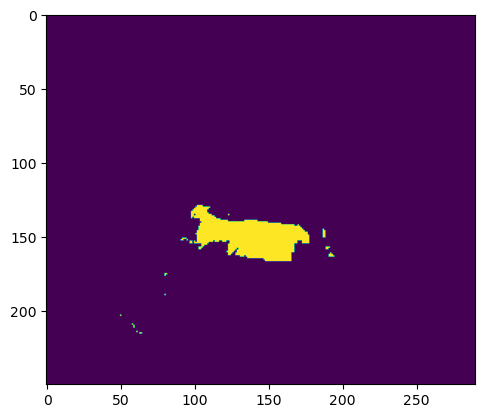

In [68]:
plt.imshow(green_and_multi.loc[id, year][150:400, 610:900])

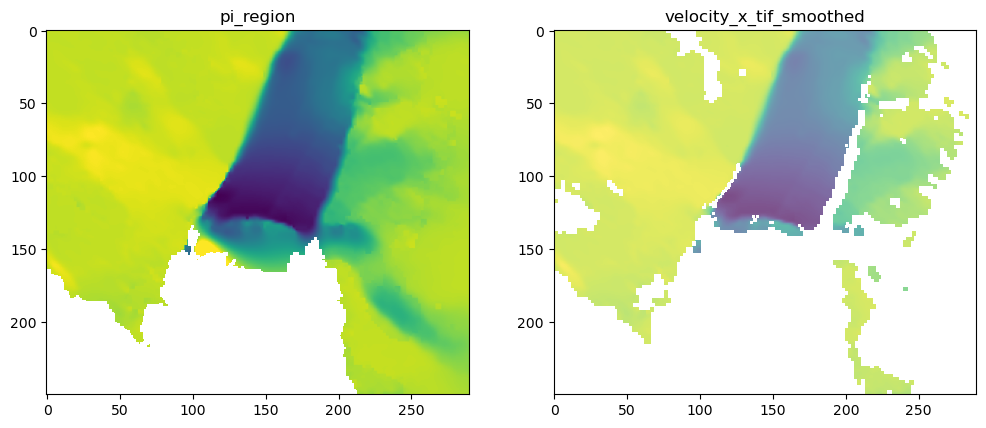

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

year = 2012

# Plot the first image
axes[0].imshow(pi_region.loc[1, year], cmap='viridis')
axes[0].set_title('pi_region')

# Plot the second image with some transparency (alpha parameter)
axes[1].imshow(velocity_x_tif_smoothed.loc[1, year][150:400, 610:900], cmap='viridis', alpha=0.7)
axes[1].set_title('velocity_x_tif_smoothed')

plt.show()


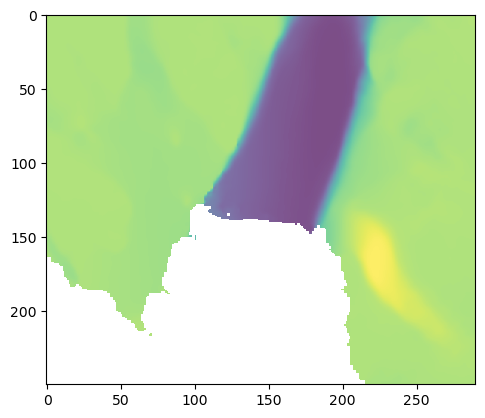

In [196]:
plt.imshow(v_y_final_3.loc[id, 2013][150:400, 610:900], cmap='viridis', alpha=0.7)
#plt.imshow(ice_mask.loc[id, 2013][150:400, 610:900], alpha=0.3, cmap='viridis')

In [212]:
velocity = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:

        velocity.loc[id, year] = np.sqrt(v_x_final_3.loc[id, year]**2 + v_y_final_3.loc[id, year]**2)

In [48]:
plot_images_to_pdf(interpolated_floating_ice_copy,'v_x', common_years)

In [117]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages

def plot_images_to_pdf(dataset, prefix, common_years, vmin = None, vmax = None):
    # Specify the output PDF file
    output_pdf_file = f'output_graphs_v_{prefix}_final_3.pdf'

    # Create a PdfPages object to save the figures
    with PdfPages(output_pdf_file) as pdf:
        # Iterate over each year
        for year in range(common_years[0], common_years[-1] + 1):
            # Create a 2x2 grid of subplots
            fig, axs = plt.subplots(2, 2, figsize=(10, 10))

            # Plot the first image in the top-left subplot
            axs[0, 0].imshow(dataset.loc[1, year], vmin=vmin, vmax=vmax)
            axs[0, 0].set_title(f'Year: {year} Full Image, \n component {prefix}')
            cbar = plt.colorbar(axs[0, 0].imshow(dataset.loc[1, year]), ax=axs[0, 0])

            # Plot the second image in the top-right subplot
            axs[0, 1].imshow(dataset.loc[1, year][400:750, 650:1500], vmin=vmin, vmax=vmax)
            axs[0, 1].set_title(f'Cropped Image 1')
            cbar = plt.colorbar(axs[0, 1].imshow(dataset.loc[1, year][400:750, 650:1500]), ax=axs[0, 1])

            # Plot the third image in the bottom-left subplot
            axs[1, 0].imshow(dataset.loc[1, year][100:450, 550:900], vmin=vmin, vmax=vmax)
            axs[1, 0].set_title(f'Cropped Image 2')
            cbar = plt.colorbar(axs[1, 0].imshow(dataset.loc[1, year][100:450, 550:900]), ax=axs[1, 0])

            # Plot the fourth image in the bottom-right subplot
            axs[1, 1].imshow(dataset.loc[1, year][0:200, 0:200], vmin=vmin, vmax=vmax)
            axs[1, 1].set_title(f'Cropped Image 3')
            cbar = plt.colorbar(axs[1, 1].imshow(dataset.loc[1, year][0:200, 0:200]), ax=axs[1, 1])

            # Draw rectangles on the first image
            rect_1 = patches.Rectangle((650, 400), 850, 350, linewidth=2, edgecolor='r', facecolor='none')
            axs[0, 0].add_patch(rect_1)

            rect_2 = patches.Rectangle((550, 100), 350, 350, linewidth=2, edgecolor='b', facecolor='none')
            axs[0, 0].add_patch(rect_2)

            rect_3 = patches.Rectangle((0, 0), 200, 200, linewidth=2, edgecolor='g', facecolor='none')
            axs[0, 0].add_patch(rect_3)

            # Adjust layout for better spacing
            plt.tight_layout()

            # Save the current figure to the PDF
            pdf.savefig()

            # Close the figure
            plt.close()

# Example usage:
# Assuming you have the 'velocity' dataset, 'common_years', and want to plot images for 'y' dataset.
# plot_images_to_pdf(velocity, 'y', common_years)


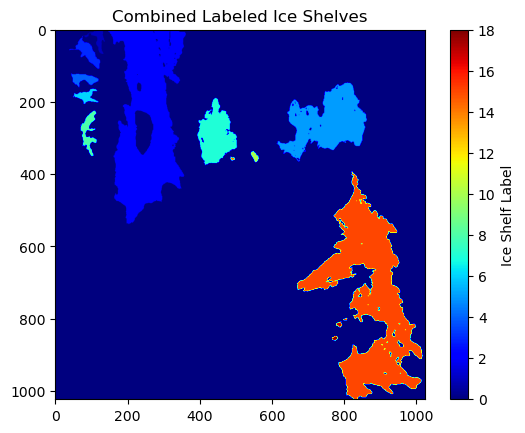

In [256]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label

ice_shelf_mask = ice_mask.loc[1, 2008]

# Assuming you have a mask called 'ice_shelf_mask'
# Perform connected component labeling on the mask
labeled_mask, num_labels = label(ice_shelf_mask)

# Create a new array to hold the labeled mask with unique labels for each ice shelf
labeled_combined = np.zeros_like(labeled_mask)

# Assign unique labels to each ice shelf
for label_idx in range(1, num_labels + 1):  # Start from 1 to exclude background label
    ice_shelf = labeled_mask == label_idx
    labeled_combined[ice_shelf] = label_idx

# Visualize the combined labeled mask
plt.imshow(labeled_combined, cmap='jet')  # 'jet' colormap for better visualization of separate labels
plt.colorbar(label='Ice Shelf Label')
plt.title('Combined Labeled Ice Shelves')
plt.show()


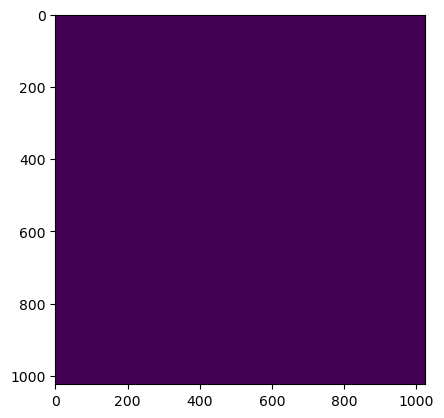

In [284]:
prova = labeled_combined == 21
plt.imshow(prova, cmap='viridis')

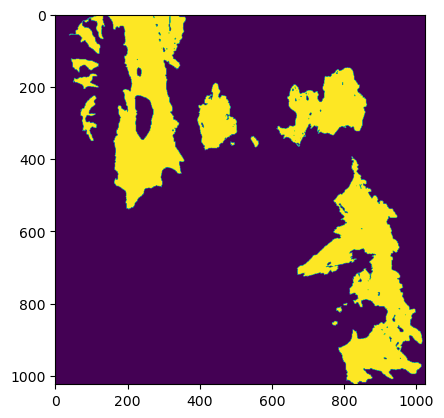

In [255]:
plt.imshow(ice_mask.loc[1, 2008], cmap='viridis')

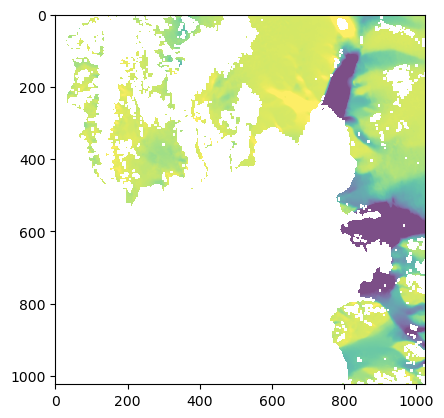

In [ ]:
plt.imshow((velocity_x_tif_smoothed.loc[1, 2015]), cmap='viridis', vmin=-1000, vmax=100, alpha=0.7)

I will go step by step here

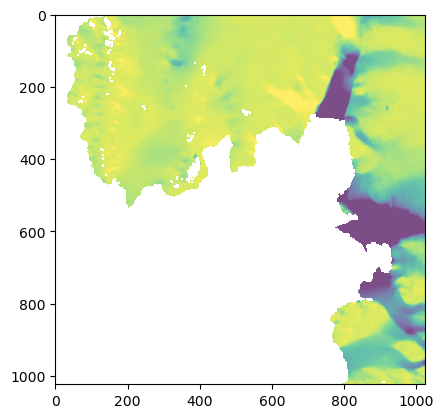

In [ ]:
year = 2005
prova = velocity_multi_and_single_2.loc[1, year]
plt.imshow(prova, cmap='viridis', alpha=0.7, vmin=-1000, vmax=100)



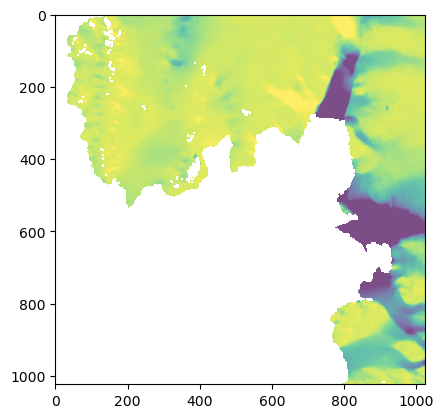

In [ ]:
prova[green_and_multi.loc[1, year]] = np.nan
plt.imshow(prova, cmap='viridis', alpha=0.7, vmin=-1000, vmax=100)

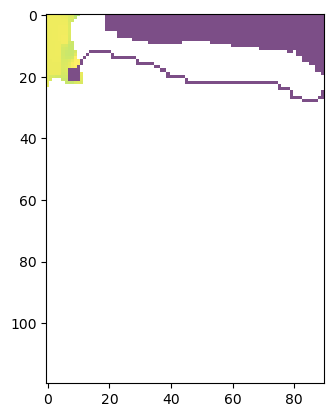

In [ ]:
prova[thwaites_boarders.loc[1,year]] = thwaites_boarders_average_x.loc[1, year]
prova[pine_island_boarder.loc[1,year]] = pine_island_boarders_average_x.loc[1, year]

plt.imshow(prova[280:400,700:790], cmap='viridis', alpha=0.7, vmin=-1000, vmax=100)

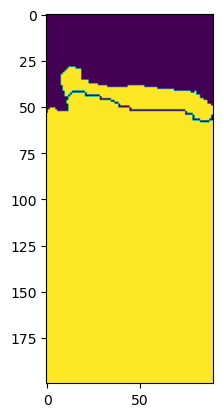

In [ ]:
#mask of where is nan
mask_nan = np.isnan(prova)
plt.imshow(mask_nan[250:450,700:790], cmap='viridis')

In [ ]:
#make the interpolation with inpaint
prova = inpaint.inpaint_biharmonic(prova, mask_nan)

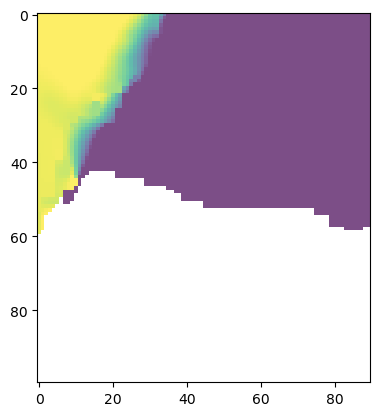

In [ ]:
prova_2 = prova.copy()
prova_2[sea_mask.loc[1, year]] = np.nan
plt.imshow(prova_2[250:350,700:790], cmap='viridis', alpha=0.7, vmin=-1000, vmax=100)

In [ ]:
v_x_final = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:
            
        prova = velocity_multi_and_single_2.loc[id, year]
        prova[green_and_multi.loc[id, year]] = np.nan
        prova[thwaites_boarders.loc[id,year]] = thwaites_boarders_average_x.loc[id, year]
        #prova[pine_island_boarder.loc[id,year]] = pine_island_boarders_average_x.loc[id, year]
        mask_nan = np.isnan(prova)
        prova = inpaint.inpaint_biharmonic(prova, mask_nan)
        prova[sea_mask.loc[id, year]] = np.nan           

        v_x_final.loc[id, year] = prova 

KeyboardInterrupt: 

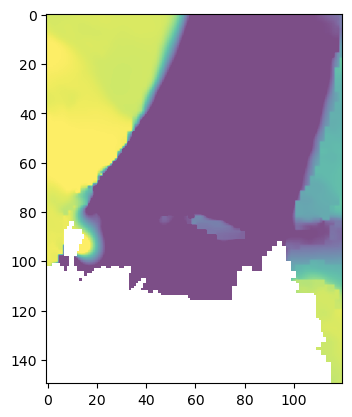

In [ ]:
plt.imshow(v_x_final.loc[1, 2012][200:350,700:820], cmap='viridis', alpha=0.7, vmin=-1000, vmax=100)

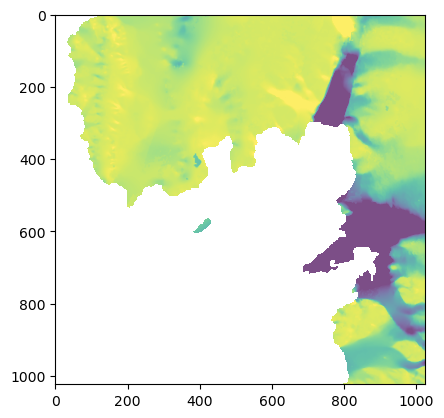

In [ ]:
for year in [2011,2012]:
    mask = 


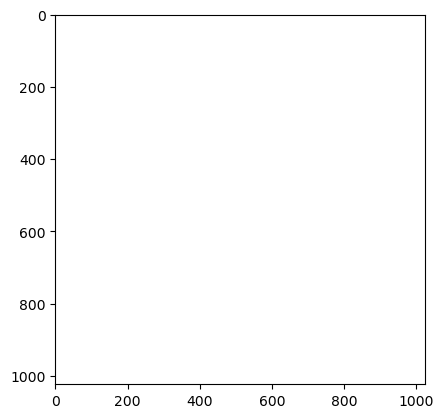

In [ ]:
#plt.imshow(velocity_multy_years_x.loc[1, 'image'][500:800,600:900], cmap='viridis', vmin=-1000, vmax=100, alpha=0.3)
plt.imshow(ice_mask.loc[1, 2005], cmap='viridis', alpha=0)